## Summary
Topic modelling in this section was done to process the main topics of the reviews on Reddit and Steam.

1. Wordcloud
   - For negative and positive Reddit reviews pre-release (before 7 Feb 2023)
   - For negative and positive Reddit reviews post-release (after 7 Feb 2023)


2. Network Analysis
   - Generate top ranked negative Steam comments (from 10 Feb 2023 to 14 Feb 2023)


3. NMF
   - Generate top 5 topics from negative Steam comments (from 10 Feb 2023 to 14 Feb 2023)

## Import Packages

In [21]:
# Import packages
import requests
import numpy as np
import pandas as pd
import re
import os
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import string
nltk.download('omw-1.4')
import networkx as nx
from time import time
from heapq import nlargest
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib as mpl
from PIL import Image
from nltk import punkt, word_tokenize, bigrams, ngrams
from nltk.util import ngrams
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\helen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 1. Reddit Reviews

### 1.1 Data Cleaning

In [3]:
# Load file
df = pd.read_csv('predict_output_xgb.csv')
df['pred_sentiment'].value_counts()

neutral     15237
positive     7704
negative     4454
Name: pred_sentiment, dtype: int64

In [4]:
# Check for nan value
df.cleaned_content.isna().sum()

88

In [5]:
# Remove NaN values
df_cleaned = df[df['cleaned_content'].notna()]
df_cleaned.head()

,created,id,content,num_comments,score,type,post_affiliation,cleaned_content,pred_sentiment
0,10/2/2023 5:01,10y62p3,It be crucial,298.0,6642,post,NaN,crucial,positive
1,10/2/2023 7:13,j7wremr,I hate casting Revelio just slightly too far a...,NaN,714,comment,10y62p3,hate casting revelio slightly far away field g...,negative
2,10/2/2023 6:33,j7wlltr,There’s a talent to upgrade the distance. Anyo...,NaN,114,comment,10y62p3,’ talent upgrade distance anyone know much muc...,negative
3,10/2/2023 9:03,j7x6q78,Quality of life change......keep Lumos on when...,NaN,100,comment,10y62p3,quality life changekeep lumos casting revelio,neutral
4,10/2/2023 5:14,j7w97d8,I just hate that it took me a solid 5 hours be...,NaN,336,comment,10y62p3,hate took solid 5 hour realized chime sound me...,positive


In [6]:
# Comments before 7 Feb
df['date'] = pd.to_datetime(df['created'])
before7feb = df[df['date'] < '2023-07-02']
before7feb.head()

,created,id,content,num_comments,score,type,post_affiliation,cleaned_content,pred_sentiment,date
82,13/8/2022 0:01,wmowau,Release date announced!,978.0,5043,post,NaN,release date announced,neutral,2022-08-13 00:01:00
83,13/8/2022 0:05,ik0dxoz,[Official source here.](https://twitter.com/Ho...,NaN,1,comment,wmowau,official source herehttpstwittercomhogwartsleg...,neutral,2022-08-13 00:05:00
84,13/8/2022 0:12,ik0f0br,Not the release date we wanted but now that we...,NaN,311,comment,wmowau,release date wanted least specific date rest e...,neutral,2022-08-13 00:12:00
85,13/8/2022 0:53,ik0lmq0,Damn i have 3 weeks off around christmas and w...,NaN,100,comment,wmowau,damn 3 week around christmas wa really looking...,positive,2022-08-13 00:53:00
86,13/8/2022 0:06,ik0e2e7,"""Hogwarts Legacy will launch on February 10, 2...",NaN,554,comment,wmowau,hogwarts legacy launch february 10 2023 playst...,neutral,2022-08-13 00:06:00


In [7]:
# Comments after 7 Feb
after7feb = df[df['date'] > '2023-07-02']

after7feb.head()

,created,id,content,num_comments,score,type,post_affiliation,cleaned_content,pred_sentiment,date
0,10/2/2023 5:01,10y62p3,It be crucial,298.0,6642,post,NaN,crucial,positive,2023-10-02 05:01:00
1,10/2/2023 7:13,j7wremr,I hate casting Revelio just slightly too far a...,NaN,714,comment,10y62p3,hate casting revelio slightly far away field g...,negative,2023-10-02 07:13:00
2,10/2/2023 6:33,j7wlltr,There’s a talent to upgrade the distance. Anyo...,NaN,114,comment,10y62p3,’ talent upgrade distance anyone know much muc...,negative,2023-10-02 06:33:00
3,10/2/2023 9:03,j7x6q78,Quality of life change......keep Lumos on when...,NaN,100,comment,10y62p3,quality life changekeep lumos casting revelio,neutral,2023-10-02 09:03:00
4,10/2/2023 5:14,j7w97d8,I just hate that it took me a solid 5 hours be...,NaN,336,comment,10y62p3,hate took solid 5 hour realized chime sound me...,positive,2023-10-02 05:14:00


### 1.2 Word Cloud for Comments before 7 Feb 2023

### 1.2.1 Negative Reviews

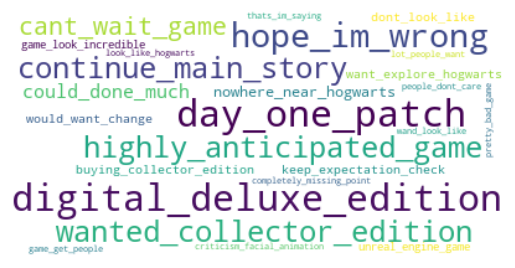

In [10]:
# filtering the rows where Credit-Rating is Fair
negativebef = before7feb[before7feb['pred_sentiment'].str.contains('negative')]

# generate unigrams 
unigrams  = (
    negativebef['cleaned_content'].str.lower()
                .str.replace(r'[^a-z\s]', '')
                .str.split(expand=True)
                .stack())

# generate bigrams by concatenating unigram columns
bigrams = unigrams + '_' + unigrams.shift(-1)
# generate trigrams by concatenating unigram and bigram columns
trigrams = bigrams + '_' + unigrams.shift(-2)

# concatenate all series vertically, and remove NaNs
description = pd.concat([trigrams]).dropna().reset_index(drop=True)

description1 = " ".join(review for review in description)

# Remove words that will appear commonly but has not impact on review:
stopwords = set(STOPWORDS)
stopwords.update(["harry_potter_fan","gon_na_make","open_world_game","dark_art_tower","game_really_hope","ive_ever_seen",
                 "hope_game_ha","gon_na_lie","dont_get_people","feel_like_people","game_ever_made","hogwarts_legacy_game",
                 "ive_never_understood","holy_shit_hope","im_gonn_na","game_gon_na","dream_come_true","probably_gon_na",
                 "gon_na_get","wan_na_know","red_dead_redemption","gon_na_wait","defense_dark_art","feel_like_would","wont_able_cast",
                 "cant_even_get","people_want_game","make_sense_game","ill_probably_end","dont_wan_na","gon_na_go","last_gen_console",
                 "anyone_else_notice","still_excited_game","wish_someone_would","mean_look_like","second_thought_wa","game_im_going",
                 "cant_wait_see","almost_every_game","im_glad_theyve","game_day_one","like_hogwarts_legacy","well_gon_na","gon_na_like",
                 "cant_say_im","want_play_game","lego_harry_potter","like_really_want","feel_like_game","make_feel_like",
                 "feel_like_going","game_even_yet","separate_spell_set","gryffindor_common_room","open_world_rpg","ubi_soft_rpg",
                 "game_even_yet","look_like_theyre","harry_potter_game","look_like_going","im_gon_na","game_look_like","oh_hell_yeah",
                 "youre_gon_na","still_got_ta","we've_waited_long","spell_automatically_equip","gon_na_stop","complete_side_quest",
                 "dont_even_know","ubisoft_open_world","man_hope_die","game_pretty_much","people_would_like","time_game_year","ce_ive_ever",
                 "way_gon_na","every_major_game","youre_paying_game","review_bomb_game","weve_waited_long","dlc_next_game","playstation_sony_get",
                 "tomorrow_gon_na","dont_kmow_make","got_ta_wait","open_world_action","levioso_arresto_momentum","thing_ive_seen","wont_even_get",
                 "day_one_instead","gobstone_wizard_chess","dont_know_make","cant_believe_people","game_come_people","dont_know_ill","paying_amount_money",
                 "collector_edition_im","gobstones_wizard_chess","paying_amount_money","still_gon_na","like_emma_watsons","said_fuck_pc",
                 "making_look_like","get_play_game","yeah_gon_na","wa_gon_na","like_emma_watson","planning_getting_digital","wizard_let_you",
                 "kinda_wish_wa","console_play_game","prisoner_azkaban_game","buy_physical_copy","people_dont_even","wish_people_would",
                 "still_good_month","gon_na_preorder","waiting_game_since","wizard_let_u","lol_dont_care","game_people_saying","game_people_saying"])

# Generate a WordCloud
wordcloud = WordCloud(stopwords=stopwords,background_color="white",max_words = 25).generate(description1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 1.2.2 Positive Reviews

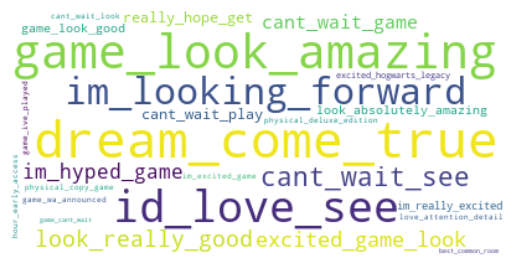

In [11]:
# filtering the rows where Credit-Rating is Fair
positivebef = before7feb[before7feb['pred_sentiment'].str.contains('positive')]

# generate unigrams 
unigrams  = (
    positivebef['cleaned_content'].str.lower()
                .str.replace(r'[^a-z\s]', '')
                .str.split(expand=True)
                .stack())

# generate bigrams by concatenating unigram columns
bigrams = unigrams + '_' + unigrams.shift(-1)
# generate trigrams by concatenating unigram and bigram columns
trigrams = bigrams + '_' + unigrams.shift(-2)

# concatenate all series vertically, and remove NaNs
description = pd.concat([trigrams]).dropna().reset_index(drop=True)

description1 = " ".join(review for review in description)

# Remove words that will appear commonly but has not impact on review:
stopwords = set(STOPWORDS)
stopwords.update(["im_gon_na","make_feel_like","ravenclaw_common_room","common_room_look","harry_potter_fan","gon_na_lie",
                 "harry_potter_game","game_look_like","game_gon_na","slytherin_common_room","hufflepuff_common_room",
                 "quidditch_world_cup","gryffindor common_room","harry_potter_universe","open_world_rpg","love_harry_potter",
                 "open_world_game","gon_na_good","game_harry_potter","fantastic_beast_movie","lego_harry_potter","god_war_ragnarok",
                 "wa_gon_na","dont_wan_na","red_dead_redemption","hogwarts_legacy_game","game_feel_like","gryffindor_common_room",
                 "probably_gon_na","play_hogwarts_legacy","gon_na_get","would_love_see","common_room_im","harry_potter_wa","like_gon_na",
                 "come_back_benign","got_ta_say","able_play_game","im_pretty_sure","gon_na_play","walking_around_castle","single_player_game",
                 "half_blood_prince","look_like_im","gam_wa_announced","definitely_gon_na","harry_potter_rpg","ive_played","thing_dont_like"])

# Generate a WordCloud
wordcloud = WordCloud(stopwords=stopwords,background_color="white",max_words = 25).generate(description1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 1.3 Word Cloud for Comments after 7 Feb 2023

### 1.3.1 Negative Reviews

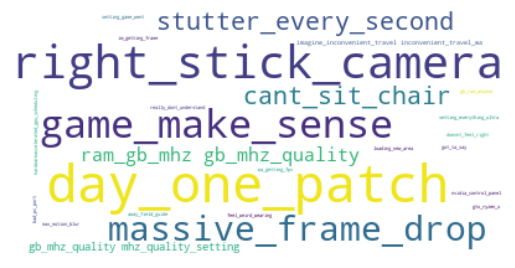

In [12]:
# filtering the rows where Credit-Rating is Fair
negativeaft = after7feb[after7feb['pred_sentiment'].str.contains('negative')]

# generate unigrams 
unigrams  = (
    negativeaft['cleaned_content'].str.lower()
                .str.replace(r'[^a-z\s]', '')
                .str.split(expand=True)
                .stack())

# generate bigrams by concatenating unigram columns
bigrams = unigrams + '_' + unigrams.shift(-1)
# generate trigrams by concatenating unigram and bigram columns
trigrams = bigrams + '_' + unigrams.shift(-2)

# concatenate all series vertically, and remove NaNs
description = pd.concat([trigrams]).dropna().reset_index(drop=True)

description1 = " ".join(review for review in description)

# Remove words that will appear commonly but has not impact on review:
stopwords = set(STOPWORDS)
stopwords.update(["k_gb_ram","walking_around_hogwart","x_gb_ram","open_world_game","im_gon_na","harry_potter_game","gb_ram_p",
                 "ryzen_x_gb","character_look_like","like_oh_shit","walking_around_hogwarts","gaming_circle_jerk","ray_trcing_fps",
                 "visit_gaming_circle","ryzen_x_gpu","cpu_ryzen_x","fast_travel_game","like_playing_game","doesnt_matter_youre",
                 "super_rare_animal","im_pretty)sure","asian_skin_tone","run_around_hogwarts","assassin_creed_wand","ray_tracing_fps",
                 "harry_potter_fan","want_get_lost","bad_gc_port","game_wa_never","was_getting_fps","game_gon_na","cpu_ik_gpu",
                 "i_k_gb","invented_floo_powder","feel_like_im","field_guide_page","hufflepuff_common_room","horizon_forbidden_west",
                 "thing_ive_heard","gon_na_get","day_night_cycle","snape_kill_dumbledore","inconenient_travel_wa","almost_every_game",
                  "travel_wa_invented","travel_wa_invented","wa_invented_floo","edit_wa_wrong","anyone_else_feel","stuff_like_would",
                 "game_take_place","always_thought_wa"])

# Generate a WordCloud
wordcloud = WordCloud(stopwords=stopwords,background_color="white",max_words = 25).generate(description1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 1.3.2 Positive Reviews

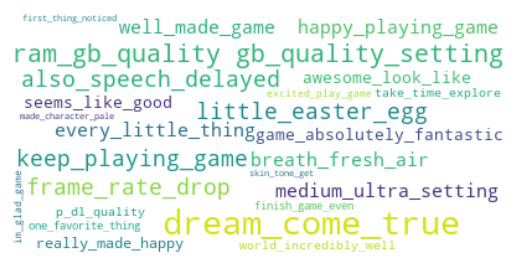

In [13]:
# filtering the rows where Credit-Rating is Fair
positiveaft = after7feb[after7feb['pred_sentiment'].str.contains('positive')]

# generate unigrams 
unigrams  = (
    positiveaft['cleaned_content'].str.lower()
                .str.replace(r'[^a-z\s]', '')
                .str.split(expand=True)
                .stack())

# generate bigrams by concatenating unigram columns
bigrams = unigrams + '_' + unigrams.shift(-1)
# generate trigrams by concatenating unigram and bigram columns
trigrams = bigrams + '_' + unigrams.shift(-2)

# concatenate all series vertically, and remove NaNs
description = pd.concat([trigrams]).dropna().reset_index(drop=True)

description1 = " ".join(review for review in description)

# Remove words that will appear commonly but has not impact on review:
stopwords = set(STOPWORDS)
stopwords.update(["im_gon_na","harry_potter_game","really_feel_like","open_world_game","harry_potter_fan","single_player_fan",
                 "id_love_see","love_running_around","lord_ring_game","single_player_game","castle_feel_like","game_ive_played",
                 "star_war_game","game_wa_made","harry_potter_book","game_feel_like","blah_blah_blah","feel_like_im","game_gon_na",
                 "slytherin_common_room","gon_na_like","game_harry_potter","felt_like_wa","fan_harry_potter","even_harry_potter",
                 "nvidia_control_panel","ever_seen_game","make_feel_like","game_ever_played","defence_dark_art","gon_na_lie",
                 "horizon_zero_dawn","sleep_last_night","harry_potter_universe","dont_get_wrong","world_feel_like","feel_like_kid",
                 "game_hogwarts_legacy","feel_like_still","open_world_rpg","like_harry_potter","thing_common_room","would_love_sit",
                 "game_look_like","feel_like_going","like_look_like","feel_like_first","wa_really_nice","field_guide_page",
                 "cant_wait_game","gon_na_get","wa_like_oh","im_pretty_sure","one_thing_would","last_night_playing","ive_running_around",
                 "would_love_play","one_first_thing","play_harry_potter","horizon_forbidden_west","gaming_circle_jerk","every_single_time",
                 "hogwarts_legacy_played","lol_im_glad","walking_around_hogwarts","excited_play_tomorrow","harry_potter_rpg","medium_ultra_setting"
                 "main_story_quest","put_slytherin_well","really_wasnt_expecting","hour_game_really","yes_wa_thinking","using_amd_fsr","one_best_game",
                 "cant_wait_play","main_story_quest","hour_pretty_good","im_hour_game","still_find_funny","look_amazing_look","im_looking_forward",
                 "like_wa_good","im_really_glad","every_inch_castle","wa_harry_potter","ive_never_read","higher_level_im","like_wa_good",
                 "well_thank_god","dark_art_soul","great_game_far","explore_every_inch","looking_forward_getting","play_like_game","great_game_far",
                 "say_harry_potter","huffle_puff_common_room","played_dark_soul","use_fast_travel","always_feel_like","feel_like_everything","say_coming_feb",
                 "long_time_since","many_hour_game","outside_hogwarts_saw","havent_watch_movie","hufflepuff_common_room","love_playing_skyrim",
                 "couple_hour_ago","always_get_love","even_hp_fan","havent_watched_movie","mean_harry_potter","wa_worried_wed","hogwarts_legacy_wa",
                 "game_every_time","im_glad_im","wizarding_world_movie","game_story_one","game_ha_many","wa_happy_see","time_feel_like","game_wa_one",
                  "time_feel_like","actual_fucking_wizard","open_world_harry","in_glad_game","wa_running_around","time_ive_yet","ill_like_im","would_never_know",
                  "wouldnt_time_play","would_never_known","life_hour_day","harry_potter_cant","wa_first_thing"])

# Generate a WordCloud
wordcloud = WordCloud(stopwords=stopwords,background_color="white",max_words = 25).generate(description1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 2. Steam Reviews

### 2.1 Data Scraping

In [14]:
# Obtaining negative comments from Steam
def get_reviews(appid, params={'json':1}):
        url = 'https://store.steampowered.com/appreviews/'
        response = requests.get(url=url+appid, params=params, headers={'User-Agent': 'Mozilla/5.0'})
        return response.json()

In [15]:
# Obtaining only negative reviews
def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
            'json' : 1,
            'filter' : 'all',
            'language' : 'english',
            'day_range' : 9223372036854775807,
            'review_type' : 'negative',
            'purchase_type' : 'all'
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    return reviews

In [17]:
# Input Hogwarts Legacy's AppID, and the number of reveiws to return
reviews = get_n_reviews("990080",10000)
df = pd.DataFrame (reviews)
df.timestamp_created = df.timestamp_created.apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,134631955,"{'steamid': '76561198039483816', 'num_games_ow...",english,Hogwarts Legacy has a lot going for it. It is ...,2023-03-14,1678765084,False,1412,36,0.845633506774902344,47,True,False,False,True,
1,134810482,"{'steamid': '76561199477113075', 'num_games_ow...",english,I really want to love this game. But unfortuna...,2023-03-17,1679056694,False,50,2,0.766874492168426514,2,True,False,False,True,
2,132670654,"{'steamid': '76561198011188250', 'num_games_ow...",english,First of all. \nI really liked the game up unt...,2023-02-12,1676166987,False,3218,231,0.75522768497467041,0,False,False,False,True,
3,132537973,"{'steamid': '76561198124407909', 'num_games_ow...",english,[I]Overrated Game of The Year[/I]\n\nI know th...,2023-02-11,1676905376,False,426,17,0.750850975513458252,106,True,False,False,True,
4,132695404,"{'steamid': '76561198060509134', 'num_games_ow...",english,I strongly believe that this game would not be...,2023-02-12,1676198049,False,1196,55,0.736910223960876465,102,False,False,False,True,


In [18]:
# Filtering dataset from 10 Feb to 14 Feb
data = df.loc[pd.to_datetime(df['timestamp_created'])<datetime(2023,2,15,0,0,0)].reset_index(drop = True)
data = data.loc[pd.to_datetime(data['timestamp_created'])>datetime(2023,2,9,0,0,0)].reset_index(drop = True)
data.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,132670654,"{'steamid': '76561198011188250', 'num_games_ow...",english,First of all. \nI really liked the game up unt...,2023-02-12,1676166987,False,3218,231,0.75522768497467041,0,False,False,False,True,
1,132537973,"{'steamid': '76561198124407909', 'num_games_ow...",english,[I]Overrated Game of The Year[/I]\n\nI know th...,2023-02-11,1676905376,False,426,17,0.750850975513458252,106,True,False,False,True,
2,132695404,"{'steamid': '76561198060509134', 'num_games_ow...",english,I strongly believe that this game would not be...,2023-02-12,1676198049,False,1196,55,0.736910223960876465,102,False,False,False,True,
3,132741839,"{'steamid': '76561198017918223', 'num_games_ow...",english,[h1]Summary[/h1]\nHogwarts Legacy is the best ...,2023-02-13,1676243440,False,214,9,0.720772981643676758,66,True,False,False,True,
4,132545487,"{'steamid': '76561198169544071', 'num_games_ow...",english,"couldn't name my character poopy butt, a singl...",2023-02-11,1676057054,False,1353,429,0.711584806442260742,125,True,False,False,True,


### 2.2 Data Cleaning

In [22]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
# Adding on to the list of stopwords to be specific to our game
stop_words.extend(['harry','potter','game','hogwarts','play'])
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    #define regex for urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text) # Remove URLs
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Return cleaned text after removing Nones
    tokens = list(filter(lambda x: x is not None, tokens))
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\helen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
comments = data['review']
processed_data = comments.apply(preprocess_text)
df = pd.concat({'content': comments,
              'cleaned_content': processed_data}, axis=1)
print(df)
#get unique tokens and collapse into a single string
df['cleaned_unique'] = df['cleaned_content'].apply(lambda x: " ".join(np.unique([token for token in word_tokenize(x)])))

                                                content  \
0     First of all. \nI really liked the game up unt...   
1     [I]Overrated Game of The Year[/I]\n\nI know th...   
2     I strongly believe that this game would not be...   
3     [h1]Summary[/h1]\nHogwarts Legacy is the best ...   
4     couldn't name my character poopy butt, a singl...   
...                                                 ...   
2706  I installed the game on 2/8 and played perfect...   
2707  I really want to recommend this game, however ...   
2708  Where can i find the ray tracing optimization ...   
2709  First I kind of dismissed Hogwarts Legacy, bec...   
2710  Good game, definitely, but not optimized for P...   

                                        cleaned_content  
0     first really liked end finished campaign stuff...  
1     ioverrated yeari know piss many people seeing ...  
2     strongly believe would popular wasnt world obv...  
3     h1summaryh1 legacy best date merit current pri...  
4

### 2.3 Network Analysis

In [9]:
start = time()
sentences = df['cleaned_unique']

#initialize graph object
graph = nx.Graph()
graph.add_nodes_from(range(len(sentences)))

#compare sentences with each other and add an edge between nodes if there are common words, 
#with the weight of the edge being equal to the proportion of words they have in common
for i in range(len(sentences)):
    curr_sent = set(
        np.unique(
            [token for token in word_tokenize(sentences[i]) if (str(token).isalpha() == True)]
        )
    )
    print(f"[{i}] {sentences[i]}")
    for j in range(i + 1, len(sentences)):
        compare_sent = set(
            np.unique(
                [token for token in word_tokenize(sentences[j]) if (str(token).isalpha() == True)]
            )
        )
        #get ratio of common word count and total length of the sentences
        common_words = len(curr_sent & compare_sent)*2/np.max([1, (len(curr_sent) + len(compare_sent))])
        #if there are common words, add edge between the two nodes
        if common_words > 0:
            graph.add_edge(i, j, weight = common_words)

#calculate pagerank for each sentence
pagerank = nx.pagerank(graph)

#calculate the n_sent sentences to extract such that we are only keeping ~30% of the sentences from the original text
n_sent = int(np.ceil(0.01 * len(sentences)))

#get top n sentence based on pagerank score if the paragraph is longer or equal to n sentences.
#else, take all sentences that are available (which is 1). sort key_points to keep sentences in correct order
key_points = sorted(nlargest(np.min([n_sent, len(sentences)]), pagerank, key = pagerank.get))
print(f"sentence count: {n_sent} | compression ratio: {len(key_points)/len(sentences):.2f} | took {time() - start:.3f} seconds:")
for l in key_points:
    print(sentences[l])

[0] 0 3 5 97 actually amazing anything apart artwork avoid back beeing betraying campaign cared challenge character choice chose colour combined common completion considering curse dark decision different easily else enchantment end ending even everything extorting feel feeling finished first gear get giver happens hard hero house i76700k isnt issue i´m learning like liked literally made many mattered maybe might neither nice nobody none normal nothing npc overpowered p pc playable point possible power probably pushed put quest really replay right room rude sad said see side soundtrack spend stuff stuttering take talent tbh thing total unforgivable unforgiveables unless used v value voiceline wa want whatever whenever yaaaaaay
[1] 100 20 2023 23gb 5 50 67 achievement acquired actionadventure actual actually add added adding addition affect ai almost alohomora already also always another anything appealing around art artificial asked atmosphere attention authority bad battle bearsonalit

[9] 1 1010 2 3 6510 aaa affection anything app ascendio barely book btw care casual combat combo console content crash current curse day decent devs died difficulty discover disregarding dl dont dreamed drop element else enjoy even exclusive fan feature fight first fix fps free gamer get ghost go greatly ha hard helped hereby hogsmeade hotfix hp installing issue latest leak learn leaving legendary linear lower lucky massive mediocre memory mod much must negative nexusmods occasional ollivander open overall owner pc performance personally plant pleb poor potion probably ps5 puzzle rather ray read releasing relic review rig room sale secret setting shop since something soulslike spell state story support swapper swapping talk thing thrives tracing traverse turning u unforgivable unless usage use variety version visit vsync wait well wish youre
[10] ache action active added alive also ancient appearance arent awarded badass bench boil boring break breaking bypassing cant castle chair chal

[24] cant slaughter student
[25] 1 10 11 12 1234 1800s 2 20 2010s 3 4 5 6 7 8 9 absolute active add alive also always angle annoyance another appear around attention attribute away back bad beautiful become bed begin behind belief belly boring brute buffering camera cant care central certain character charm checkbox clash class click coming complete completely console constantly country creating creative curious cutscenes cycle daynight defensive designed despawns detail developer devs different disappointed done dont door downstairs eastern effort element empty enemy enjoyable enter environment era establish etc even evening every evident except expectation explore expression far feel feeling figured final finish focus follows force friend full fully funny gameplay gear glitch god going good gorgeous got grant grounded ha havent head high himherself hogsmeade hogwartz horizontal however hp12 id ill im immersion imo implement including installed instead inventory isnt item itll key kid

[42] actual actually another asks background class collect college competition difference different dont eat everything experience floor food friend fun get hell im magic make making much nonimmersive normal open playing quest routine school shallow skin sleep someone studying take teammate ubi unless waiting wide world
[43] 6510 acted actor actually almost also another arent around art artist asset atmosphere barely basically better bug build challenging change character choice combat cool could creator decent design developed dialogue didnt different direction disappointed disjointed done drop easy even every everywhere extremely fairly feel fps get give good got ha hard hopefully im impact increasingly installed large lightning like loading lot mainly make mean move much music nonexistent nothing noticeably npc nvme option overall part pitch pleased popin presets rating really release replayability right robot say screen see sound ssd step story studio stuttering style thing unoptim

[55] beyond coupled deal deck denuvo drop end frame frustrating high insane pc rate unplayable
[56] 0 4 ahead anything anyway basically change choice continued didnt difference doesnt dont dreamt dump ending enjoy enjoyed everything evil experience fallout feel finishing force found fun go gon good happen however kinda let like literally lot magic make matter na option overall path picking playing rail real really recommend ride rpg ruined said sat say set since stick taken time wa wanted wasnt waste younger
[57] able bully bullyhogwarts going hufflepuff imagine kid legacy slytherin
[58] 10 6 7 age amazing animation arent around art boring brand cant character click combat compare computer constant constantly copied crash crashing design designed dialogue door dragon even example exploring extra fair feature feel found gating get given good halfway hard hermione human interesting learn like line loading locked magical main many maybe moment movie negative new open personality poor posi

[79] performance poor
[80] cant complaint far fixed issue pc performance recommend thats
[81] 30 breaking doesnt drain except falling fix glitch great happened infinite life make method nothing one thing time tried trying wa work worth
[82] abandoned aiming also appealing aren´t barely become boring can´t castle cave challenging character chore conveniently disappointing done enemy entertainment environment except explore field fighting fixed forest fun general generic green honestly interaction issue it´s joy lack like little location looked many map marked masterfully much npc opposite performance playing potential pretty quest reason repetitive review ruin running secret seems short smoothly spooky stay stop story summary talk there´s though unchanged variety visually waste well work would
[83] 3080 5800x abhorrent allowed available buy cant confident constantly fix great ha half highend issue least like machine optimization performance playtime point recommend relatively release sh

[89] 1020 2070 22 4060 7700x cpu dl doesnt ffs fix fps get go gpu hogsmeade lowest never performance ryzen setting ultra use want
[90] 3080ti beautiful buy laggy like love moste must one optimized patch pc performance potterworld rtx sale shit wait world
[91] 2 3 4 active actually add agile almost also amazing amount annoying anything atrocity bad bar beast beautiful benefit bestworst bland blowing bored broom building cave change character choice coff connecting console content continuously cool cooler could cripple curse customize dead design detail didnt dislike diversity doesnt dont enought ever every everything evidently example explain fact faster feel find flying forcing full gear get give giving good graphic great ha hippogryph honestly hotkey house however ill item ive keep keeping kinda lack lacking last least left let like locked look made many mechanic meh might mind modeled moral morality mostly mount mounting much need old one overall played price puzzle quest questpuzzle

[110] better boring character choice dont drop expected fps getting keep like looking matching matter money problem really something sometimes voice waste weird well
[111] 30 bad bandit broom bullsh1t camp cave character choice class combat could cutscene decent disapointment dont easily empty euro even explore fair fan feel flying forgettable good ha impressive learn like literally map matter mostly much need overall price quest quite really repetitive riddle sale seems side size spell story suggest thing waiting wanted world would yet
[112] 1080p 12gb 16gb 3060 3600x 5 75fps arrived auto constant dl drop eye fest fix fps gaming get high hogsmead hope im impressed intro legacy let like lot make medium mid omg place please ram really recommendation review rtx running ryzen say screen set setting start stutter synchronization tearing thankyou tier update worse would yes
[113] 15 70 anyone cant could drop enjoy enough fixed fps frame fun future give impossible lot many moment near optimi

[135] 60 acting actor assume away cause character coming current doe dollar driver even fast feel finish frame get giving good graphic hole hooked like loos lose match meander mile model mouth npc nvidia people plot positive put quest rating ray really review rushed sale see seems skipping start started state steam story strong synced tends tracing twist updated voice wa worth would
[136] 1 1st 2 3 4 7th able access accio achievement act activity actually advanced advancing adventure afterthought allowed allowing alone also alternate another anything area around art aspect astronomy average b barely based beast big bigger biggest blasting boring box broom bthe build building buy cairn care castle catacomb cave celestial character charm choice choosing chosen class clear collect collectible collection combat companion complete completing consist conveniently cool could creature curfew current curriculum damn dark dead defense delight deliverh1 disappears disappointment discover discover

[150] 10th 16gs 2060 addressing anything cant crazy definitely deserve doe doesnt gen good havent high i7 launch like optimized pc poorly praise quite ram really recommend recreate run running still stutter super theme though unless update well
[151] 10 2 30 50 60 air almost also annoying another appear around attention average awhile b bad book bounce bring care caught character close collect collectable collecting combat complain complaint content criticized deal decent different disclaimer doe doesnt dont dumb end even exactly fine flaw folk gamer good graphic great guess h1 happen hit hour im keep learned like liked literally littlest lot love may mean mechanic mind minor mostly movie musicsounds must never object occurs often okay open optional part pc played playing plentiful plus pointless pop popin popping poured purchase quest read reading repeat revelio review rinse said short sick side skip someone something sorta special spell spend start still stopped story student stuff t

[161] issue lot performance
[162] anymore cant config daysand even firewall never perorder recommend rundeveloper setting two wb
[163] 3080 32gb 3900x 9 change cpu drop enjoy even fixed fps got gpu huge lagging main might mission pc performance ram recommended review rtx ryzen story stuck terrible texture
[164] 20 3 520 70100 70€ back barely changing come difference drm except fact far fps go ha happening hour know lovely make mess named pay played refunded resolved right run running second setting shall
[165] 4fps deployed deviate fan fix good inclusive main modern quest refunded suck though voiceover well
[166] british people ’
[167] 144 30 action aesthetic alleviated anyone big castle dodge dropping due duel easily even exceedingly explore feel fight fly frame fun gameplay get give going good ha hairy however ill inconsistency incredible interest le like low monster one parry particular passing patched performance pretty probably puzzle rather roll rpgs setting solve soon soup spell

[183] 1 150 2 26 3 30sto40s 4 50 acromatulas act actual actually adult adventure advertised agin alive allowed always amazing animation annoying another anything appear applethe around ask asking asks attack away back background bad basically beautiful because… becoming bed begin behind best blessing boring breaking broom building bully butchering butterfly came camp cant cape care casting casual centors change character checkbox chest choice choose cinematic class click collect college combat coming competition could course curious curse cutscenes cycle danger dangerous dangling dark daynight deadly deal death deatheater decent decision defeated deny describe designed despawns desperate developer devs difference different difficulty direct disappointed divert done dont door downstairs draw eat effort elden emphasize empty ending enter entered entering entire environment equip etc even evening everything everywhere expectation expecting experience exploration expression fact far feel f

[191] 20 6 ago amount book bug cant coming exceptionel first fixed fps general good hot hour issue ive kind lag least mess movie outside performance recommend simply stuttering surface tell time wished writing year
[192] able amazing another bad cant change combat consider cut due even experience first fix frustrating going good guy ill lag magical mess moment month need opinion optimised patch patient pc poorly positive pretty real recommend remember rig scene shame stuttering two unplayable wait waiting want watch wont
[193] alone around bartering bitter bull companion complanions dai doe done encourage even existence expected extremely fallout feel feeling forget found friend friendly full garlick gathering get however instance interaction lack lead leave life like majority mc nostalgic npc offer phenomenal playing professor quest random regardless said school similarly skyrim social something sort spend stick surely take taste thought time varrik wander wizard world would yet young

[213] atrocious performance
[214] able better big bother buying common complete couple day decent definitely devs first freezing get hear hour however issue listed lot main manage many nothing past pc people problem recently recommended sadly say shaders shame silence spam spec suggestion time trying without working worth would
[215] 2nd 40 already annoying basically big buggy cant find hour laggy leak lost pc point progress save suicide thing think though time total trailer
[216] like make performance powerpoint seem slideshow
[217] 10 2 2080 25 30 5 60 acting actually allowed also app apparently average awful bass best beyond bit buck bug buggingly cardboard castle change changer character contained could cutscene damn decent decided definitely despite doe dragged drop dropped effect empty enough even every expected exploded felt find first fix fps full fullscreen funny gameplay got gtx hear honesty horrible hotfixing hour i7 id ingame inside itll leaf like looked lot low main meanin

[237] chill cracked denuvo eventually get good hold hurting hype immersion info initial kind like literal may one perfectly read really remove removed review run second shit title want
[238] 16gb crash high ram usage yet
[239] 30 abysmal also arent around book called characteristic child childhood choice class classic consequence consider crucio curse dark depulso dissonance dont eat enough example familiar fan feel fool fun gameplay garbage go good great guess happy honestly hp huge human hundred inconsistency jesus killing know last later learning like looking lord ludonarrative made make mean might montage none nothing novel others part people pick place poaching potterhead potterheads prefer pretend professor random real realistic really regular remember right running second sense sharp snape someone sorry spell story student stupid take teach teacher thing though time u understand unforgiving universe use visual wand way whatsoever work would writing wrong yeah year yes
[240] 1 14

[260] 37 able bug devastated different done everything fair far fix going helped hour however im issue ive longer loved main maybe nothing paid please post price problem progress quest review still think want whatever whats
[261] 3090 32gb 3600mhz 3900x 9 980 cant evga fixed fun issue pc performance playing pro ram recommend ryzen samsung setup ssd
[262] absolutely abysmal addressed asking blur cant disabled fight fix frame give hosmead ill im issue joke mess mitigate month motion much need otherwise pc picked playing port pretty rate really recommended refund release right scene setting stuttering troll try unplayable
[263] abhorrent absolutely around awful bit choppy cut decent delayed drop fight fps graphic im insane laggy performance player pretty released rig running scene single wa
[264] cant comp continue crashing even farther fine let load love progress review spec without wont would write
[265] better bit enough ever every fun get good however lagging new one optimised played 

[301] aaaaaaaand aka another console crappy crash decent everywhere experience fixed great learn matter port rdr2 review ruin ruined setting stutter together update
[302] 2nd 5800x3d activity almost always available ball best better castle character christ combat coming console created destroyed disappointment dogwater drag drop even field frame fun generation get giving global good guide ha hint illumination im interaction introduce introducing know last learn like main make many map march meaningful meaningless mid middle minigames moment new noise open pacing patch pc performance point port progression protagonist provided quality quest rate reason redundant rtx4080 saved secret setting side snoozefest spell start story support sustainable teleportation think throughout ubisoft ups using version wa want whole world worth would
[303] breaking bug door hard open spell tutorial
[304] 1 100 12mins 15 16 1m30s 2 20x 22 2d 2x 3 5 99 acting actually af ai allow almost also always amazing a

[331] 1524 3200 5600x3070 8gb16gb avalanche castle crowded dont drop enjoy experience fix fps joke kind place pls r5 ram really ruin staircase want yo
[332] another area certain dead dont exit feel fun get like part really rpg wrong
[333] 16gbs 2080 3 30 60fps actually amazing anyone barely buy cancel community console constant day devs dl dont enjoy every experience fix friend giving go god hard honestly hope horribly i78700 idea instead issue lag like love low medium minute money need next one optimized patch pc people player positive ram rarely recommend refund review rtx second seen setting shut single something still stuttering suffering swapping thing tried try trying turning understand use want win without wonderful would
[334] actually additional alienates alot also anymore based best big busted button challenge change club combat completely cost definitely disappointing doesnt drastic dueling easly economy else everyone except exploration feel finish focusing full fun gear get

[352] 010 called censorship character child coming contains decent devouring dinkum get holy hopefully hurt larry let level lol name negative patch player pretty ram resolved restricted review silly single smoke stuttering terrible video wont word wouldnt
[353] 13 able accordingly add alderlake already around asrock asus avx512 bios blue bought check cpu day didnt download early enable ended expected feature feb figure figuring fix get gigabyte give go gon got havent home hour ill im immediate intel isnt know leave like look looking manufacturer may milage morning much na nothing official one online patch point positive refund release review sadly said screen see seems seen seizure spent started taking team temp though tldr tweaking update vary wait warning work worked worth would wouldnt
[354] bought buying copped cost dont excited got lot money much really reason regret usually
[355] 610 bare barely bathroom beautiful beyond break bully buyer cause character common con crasheslagsbug

[375] amazing broken care completely currently doe great horrendous look made mess money obvious one pc played port ps5 purchase run save smoothly system wa
[376] bother dont like run shit
[377] 1520 cant changed dont edit fix fps fun great ha hogsmeade isnt issue loading long mainly much nothing patch performance really recommend something sometimes terrible texture two wait
[378] baby bad badly buying cry first im know money optimized performance really recommended regret review save say talking time
[379] 110fps 12gb 1440p 17gb 3080ti 32gb 5900x 722fps around back basically beautiful bit come drop due fix flaw full fully huge issue leakage lower maxed memory near optimized pc quality ram ramvram request seems start vram
[380] 1 absolute abysmal action affecting another anyway area arkham art avoided bad better boot botching cant champ changed clearly console could day depth devs disaster discount dreadful dropped edit end even every exceptional exclusive first franchise full fullscr

[413] 3 30secondsorless 5 5060 6510 95 99 acting actually amount animation annoying answer automatically awkward bad bag barely beacon beast become bed boring branching buy cant care character chest choice choose coin collectible combat complete completed con constant content copy curse customizable cutscene cutscenes daynight decent design destroy dialog disappear done dont door dungeon dungeonslarge easy end ending enemy enterable entire even everything everywhere evil expands extremely fast filler find flaw forgettable forward gear generic get go goblin good graphic grow ha half halfway hallway harness hasnt hidden highlight hogsmeades hole hour icon identical increased ingredient insignificant interesting inventory killing lack land le light like line linear loading location lock long look loot lot main making many map matter merchant merlin minigame minigames money movie much multiple music must nearly never night nobody nothing npc one open originality overall pacing pasted picki

[430] 1010 45 90 aaa absolutely actually also amazing area around bar better bias bleeding blindly blow castle copy could crowd defend detailed different dont double drop entirety ever every exist existence experience far floor follows fps going good ha hour incredible incredibly issue ive kinda knighting leak learn light lighting loading lot made memory mind need new none obnoxious outside part pasta people performance positively problem rate real reflecting restart restarting rt seen shouldnt stabilizes start stutter suffers tanking think tier time top transitioning trash trend wa wall well went white wish work world
[431] 30 away chuckle expired filled gamehad get good haha identity immersing minute politics realised refund time trap walked wanted western
[432] basically crashing far fun major problem unplayable
[433] 1 2 20 24 3 4 510 anything boot cant cast currently denuvo dont edit floating fps frame fuck go hogsmeade horribly hour issue light linux lose lot midair negative nigh

[448] absolutely broomhandling disgusting keyboardmouse
[449] could fun ran well
[450] adjusted article based becomes complication consults deeply disappointed emotion experienced extremely fixed forum friend frustrated im ive lag laggy love many matter meet much negative next patch patiently potterhead progress recommend resolve sad setting story swirl take time update waited year
[451] anyone arent aside boring buy chick child deprived dick diehard dont fan great ha isnt joke lego made mission one really star substance think visuals war
[452] 70 able abomination activist agenda alert allow ancient apart basically beer beginning behind belief blood bomb book bring broomplace butter came cant care cast castle charactersnpcs choice clearly correct crest crybaby design despite developer dining dlcs dont dramatically dumbed eat even expect finish finished first forward fourth friend fun futurethese gameplay gamers generation glitch goku grab graphical great ha half hall higher howarts how

[469] actual another armor awful boring catered collect community convinced everything extremely finish fully get give go ha im keep majority many positive quickly reason repetitive review rewarded shot skin trying
[470] aside better bit boring cant character combat controversy discount fan heard heavy issue last maximum million performance point poor really recommend rtx run set somehow story time wait youll youre youve
[471] 2077 call cyberpunk ffs goddamn ha lag lagacy le optimize please potential ridiculous solid
[472] 1 25 3rd 4 4th actually also amazing appears attack based bit boring cant combat complete day detail dislike done dont enemy enjoyed entertaining every experience explore facing fact fade feel freaky fun gone harrypotteruniversedrug keeper lame le like lol lot magic many mode multiple must need new newplayer ordeal pain people player polished queue restart right save simultaneously single slow steal stopping story thats think time trial turn u understand wa waited wa

[496] frameratus reductus
[497] 2nd become broken buy completely day deserve different doe frustrating get ha incomplete launch many matter money past preparing shader since stage step take troubleshooting unplayable
[498] aposing bug character cp2077 crash crazy like stuttering
[499] cut dropping every fps keep scene stuttering
[500] 1080p 3080 99 9900k application cant cause compilation consistently crash dl drop even fixed fps fsr furthermore gpu inexcusable instead interfering issue jarring low lower mediumhigh memory overflow performance random recommending resolution rtx run seems setting shader standard start stutter system upscaling usage using weird
[501] character droid like sound wth
[502] boot broke cant crashing day even fine help launch meet minimum one played plz required spec update without worked
[503] 60 90 amazing constantly disaster early even fps freeze generation going gon good gpu im improve keep latest lie many money na one patch pc performance problem promising

[519] 9 90 also asset best experience experienced fact fan feel fist focus hardcore hoping hp huge journal let like looking much non open progression rpg say short wa way word world would
[520] adapt annoying apparent around attend basically class crash crashing disappointing doesnt dont entire everyone evolve fooled found get go ha im impossible keep look make many moreover mountain must nothing playground practical recommend regular reporting school see sen simply solution state student therefore tried trying wait want well whats wish world yeah
[521] 6 bad cant drop frame hour need patch performance run still vomit wanting without
[522] 14030fps 4090 around constantly fact given ha jump like pas run unbelievable walking
[523] cut scene simulator
[524] 4 acting along also amazing bad better brain break cant castle character child click color combat decided detail developer die door end ending exloration exploring filled giving going highlight hour implemented interactive joke killed 

[542] assuming boost bought cant change console either ever fine fixed get happens id ill lag late lowest nvidia pc positive possibly properly really recommend refund review run set setting software state stutter tbh wish work
[543] 30 boring complete continue degenerate denuvo discouragement fired hour moment must never performance playing screenwriter work writing
[544] 0 10 1962 19th 2 5 able abundance activity agenda already also amount apart authentic available azkaban back backwards bad beautiful become bend black boring britain bubblegum buganda called candle cashing cast century chamber character chew chosen collectable combination complete completely content couldnt dated detachment detail dont entirety every everyone exactly experience feel felt ffs find franchise gameplay gimmick good graphic grind grindy guess hey hiding hold hope hoped huge imagine interesting keep kick know known lame landed lazy levellocked lgbt like location locked looking loop love loved made make map 

[568] 60 able annoying bad behind buck character cup else everything explore fest fine forspoken good graphic lock main open part snooze story storyline tea wasnt world
[569] advance ahve constantly end even getting high money note patch pc purhased purposely release stutter u untill wait wasted
[570] aspect average best cant experience gaming good graphic handle highest lose pc setting visual
[571] actually build decent doesnt ha hopefully horrid like lot month optimization optimized pc potential purchase requiresrecommends say seems take wouldnt
[572] 25 3070 60 able around dl doesnt drop due even fix fps frequent get getting like look low make max medium nice performance quality ray return rtx sense setting stuttering sudden terrible tracing wa
[573] alot although character compressed constant distorted drop fixed frame fun issue lot performance probably reason recommend robotic rtx3090 sound still stutter subpar voice would
[574] 2060 cant comment dont frame gameplay hardware much 

[599] 3080 fixed performance recommend shouldnt slideshow
[600] crash despite every meeting pc recommended requirement start time unplayable upon
[601] 1010 410 based continue due fix give good great issue lag pc performance playability please quest really recommend right serious solely story stutter though un
[602] 2077 710 amazing arkham around assassin big broken broom bubble castle change colored combat constant cookie cosmetic counter creed current cutter cyberpunk dip especially explore fix flying frame fun get great high highlight hogsmeade hogswarts honestly however isnt lag land leveled leveling like loot lot make open outside overall patch place played problem putting quest reason recent recommend released repetitive reward ridiculous right rpg run sense side similar simple spell state system thing though use well world yet
[603] 295 absolutely amazing anyone behind candidate day dont even fucking get goty immersion issue ive kill long magnificent mb one paraplegic patch pc p

[629] allegedly bit conclusion doe drop enjoying experience experiencing far fix frame fun ha however internet intro like lot may maybe mitigate none pc played powerful problem promising really run said seems setup smoothly stuttering successful though trick vary yet
[630] 10 12 16 1650 36ghz 64bit core directx gb geforce graphic gtx hdd i77700 intel lowest memory nvidia processor ram refund sadly spec storage unplayable version window
[631] accept actual also annoying arent bit british call cant castle character charming choice choose clunky combat confusing consider deny diversity dont either else empty enemy engaging enough even event everywhere f fail fan far feel fighting get grating hire huge id interesting isnt itd lesson like love magical make mediocre might minigames moving much navigate okay one overall question quicktime really rpg seriously set skip someone something sometimes special staircase stale stretch tea theyre thing warrant weird whether worth youre
[632] 30fps 510

[666] 1 100 2 along always assassin back beautiful better buy cad cast character commemorate computer creed dev difficult doe engine even exploring extremely glance glitch good grain interact item like look love man much non one op open person prodigy ran remastered run salt science sky specific spell supposed take team thing though ultra unfinished unique using wanted witcher wizarding world worth youve
[667] bug deluxe dialogue edition fixed get instead maybe releasing
[668] deleted far progress ruined wa
[669] 30 buy definetley money short way worth
[670] cant dragon refund ride sad tame ♥♥♥♥
[671] 010 4 bit cat excited far get jealous mine one petted react screen see unplayable usually
[672] 10 45h 610 alignment almost annoys anticipated assassin assure available bad bit breaking chore collectible compared completionists creed dated describe dialogue different due engaged entering even example expecting fable feel first forced gameplay gameplaywise gamers ghost goodbad graphicalwis

[704] 1440p 3090ti 4060 dl fps joke maxxed
[705] bug cant even full get past screen warning
[706] cant mr sex weasley
[707] 30 5 badlythis basic bored came care childhood compensated course depends dont dream earlier enough exploration fairly fan fanservice feel friend generic good graphic hogwart hour im kind legacy like make maybe nicely open pc performance person played point poor put quote real really recent say sense simpleminded thats thing well world year
[708] 12 also around battle constantly cpu currently doesnt end enjoy especially even every expect fan hard high however issue lag land like magical many massive much multicore one others p0 pc profile regardless riddled running said school seeing setting solid stressed strong stutter system technical turned u use utilize version wand well world would
[709] 6pm add also around better break checking corridor could curfew disappear dorm earth environment exist face gameplay hall hard including inside library like literally matter

[730] alot best boring busy character consent drop except frame graphic including keep level ok story subpar uninteresting ur wa work
[731] also aspect bad honestly ip jk l openworld owrpg paste refunded rowling rpg take wasnt worst would
[732] 510 60 along also bad boring buying completely considering cyberpunk dead doe element euro even far flat get give go got hoped house interesting linear npc offer option people pick pretty read recommend rp seen somewhat story surely ta tho wait wanted world worth would
[733] choice considering depth devoid experience feel however impact lack life limited looking making may minimal npc offer overall park personality player rpg story theme virtual world worth worthless
[734] aside boring combat controversy lame really super
[735] actually already amazing another bad blueprint boring broom choice combat crappy cutscene dialog doesnt dont even everything evil feel flying fun get halfassed hollow issue levelling like literally lot matter meaningless 

[771] actually generic go helpfulalso lifeless looking money one qq read review save someone stop
[772] broken buggy building dev get past shaders wont word
[773] 100 1520 3070 also area awful back come crash drop experienced fps patch performance random review rtx stuttering
[774] 30 3080ti 60fps access back better bit choose completely constant dl doesnt driver early engine even everything frustrating fsr latest low matter nothing nvidia rolled rtx run seemed setting since slideshow spike tweak unplayable various vsync
[775] amazing book different drop either especially familiar fan find fixed fps frequent give got ifwhen ignored movie optimization pc people read recommended review seen self story stuff stutter ta terrible ton
[776] fix frame muh pls
[777] aaa also buying choice dont fix frame halo infinite linear make matter open pc pointless rate really sick system unplayable work world
[778] 2077 able access amazing anything cant cause choppiness come computer could couldnt cyberp

[809] hell like stutter
[810] 4 ask atm avoid broken fps freeze optimization really refund stream terrible without ’
[811] 100 120 13 50h 6 70 activity actually although amazing animal avoid avoided b bad becomes better bi bombarded bunch bunforgivable buy cant care catching challenge complete con constantly convinced cost could creature crucio cultivate curseb debatable define despite done dont dumbed economy even everything excuse expect experiencing exploiting fall farce fatalistic feel first flat fun future gear get girl glimmer gold gon good graphic grim ha hardware havent herb honest honestly hope hopefully hp imperio interesting involved joke keep kind know level like line list love main make mechanic meh month na name nonexisting noticed ok one overall part person poacher poor poppy pot potion preachy premier preorder pretending pro promotes protagonist provide really resource restores sad save second sell side simply slytherin somehow story teaching technically tendency terrib

[829] 100 account annoying awkwardly benchmark bug condition consumption customer decent due etc even extreme fps framerate frustrating held high impossible ingame joke low lying maintain memory moment optimization pc poor product published publisher publishing ready run sad setting stable state stuttering unplayable
[830] ability acting actively also ambient ancient animation another attempt awful barry battle bell better big bit bland boring breathing cant certainly character characteravatar chosen city classmate cliche closing cod cyberpunk dead deal delivered dialogue dislike due else emotion enough environment etc even eye facial far fault feel feeling felt floor footstep found gfx give go going grime grit ha happen hisher home horrific im indifferent instance insurance ive kid lack least lifelesswoodenexpressionless little live living look lot magic magical main might money much mw nice nod noise oddly oh one ordeal paid passion photorealistic playing plough policy prefer problem

[854] jk right rowling wa
[855] crash else great hogwards nothing step thats
[856] crash even load shit
[857] 4 active allowed also arena big breaking bug cant delay development done even every fight fix fks freaking frustrating gaming get gotten industry insane ive keyboard launch let like long multiple name nowadays particularly patch pathetic pc playable player practically price produce product properly raise region release reload sake scene spell stable still stuck theyve time u unplayable use waited wave weekend wtf yet
[858] 1 10 2 4 add angry around beginning big boring dialogue emotional eye face first fucking get high hour like look make might month mount mouth move much multiplay npc rdr really shit sick spend star story suck value want world would
[859] 2023 absolute already another c3p0 could cut dont drop fix frame fun getting insane issue keyboard know like mapping pc performance port rate recommend ridiculous run scene show slide sound started terrible trash voice wouldn

[880] 1 10 100 12 17 18 20 40 458 60 99 absolute absolutely accomplishing actor actually agenda agree ahead allowing almost alone also always anyone anyones arbitration around article astonishing away azkaban back band banning behaving behind better book british buy call called care cared cast change channel character charge child club comment commenting community consequence continue cool copy could curse debate decided decision definition deserve deserved didnt died directed doe doesnt donate dont doom english especially even every everyone evident exclusive expression fact fan fascism figure finish first free freedom get getting give glad glitched go going got ha happening hard harder harmless hat hate health hijacking hour idea imagine intercourse jk join jumping killed know le leave legally let level licensing like line literally load loading long look main make making manipulate manipulating manual marlin mean men mention merely messed might mind misinformation misogynist missing

[909] anymorelike broken cash character crashed created cut doe dont edit even first load main maybe menuso reboot refund release requested save sceneupon sooo take trying update wait wont yea
[910] believe british cant force wokeness
[911] 410 annoying badly boring cant couldnt devs easy enjoy everyone explore hand hold intriguing inyourface lovely make meet never obvious recommend say seem stop talking thing tried type uninteresting wait want whats world would written
[912] another appears arrow best boring broken cap challenging combat control design despite detail difficult difficulty discover dont dreamlike end excitement failure far fast find flight free fulfill fun great hard im laggy leading least left location lock map mention movie obvious part point possible potential potterheads purpose quest recommend reproduced right route seeing seemingly sole sometimes specific story target thats travel use vital whether would yet
[913] 16gbs 2080 3600 3700x 7 90 absolute badly buy cad 

[954] boring buy character fighting gameplay genshin graphic impact new reason say storyline thats wrapper
[955] 10 13rd 15 150 30 3060 3200 32gb 35 4gb 5 5600x 6 7 able absolutely actually additionally aggressive air align almost also amazing amd another anymore anything appearance appears area arena arkham armor around artificially attack autosave badly basically become becomes becoming bit blocking bos break broom bubble bug bunch button camera character colored combat come compelling completely consider console controller cooled core corresponding corsair countryside cpu crash crawl customizable customize cutscenes dark decorated defeated defense defensive despite devotes dialog different difficult dip dodge dodging doesnt done dont dramatically echo effect effectively either elden electronic elephant end enemy entertaining entire especially essentially even ever expects experience fairly fantastic fauna feature feel feeling fight fine fix fixed force foretold fps frame frantically

[986] 1 big dont ha issue like playstation set texture ultra
[987] doodoo
[988] 20 available boot bug character crash creation entrance every fix forum get ill im issue ive letter listed load meet one pc read required row second see spec thing time tried try whole wont
[989] 1080 16 2015 7th 8g excited fps gig gtx i5 im lowest ram sad series setting unplayable vram wa
[990] 16gb 1899 3 3060ti 5 abide according acting animation arbitrary author background bad bothered bugged cat character colored con control covered cringe disbelief discrepancy dragon empty english especially expected expecting face filling frank gameplay goblin good half history idling ignore ill legacy level liberty main mirror mostly music mythical nice obey one performance performed physiology poor premise pro question ram reader resolution rule ryzen set shouldnt sign somewhat stance stolen student stuff stutter supposed suspension terrible texture totally trans ui universe v2 version voice wa wall wasnt way well w

[1027] 30 3040 4060 80 acting blinded buy cant could cusceens doesnt dont droping far first fix fixed fps fun gamplay give good gpu great ha horribly im issue know look low muddy negative one people quality randomly reason reccomend resource review run sometimes stand strong super supper texture think together ton untill using voice want well
[1028] ark choice combat computer denuvo drm either especially even fix ha hindered line money optimization properly run save stupid time top worse year
[1029] 10 back drew early like lynch really release stutter would
[1030] everything freeze im launch still tried unable
[1031] 23 achievement across actual adventure afterschool alive almost alone although animation annoyed anyone anything anywhere architecture area around aside ask asking assigned assignment attending avoided away baser beast behalf believable belonging bogfrog brew building buildingleveling button bystander cant care caring certain challenge character charm cheap checked choice 

[1049] corruption entirely issue save unacceptable
[1050] audio avoid constant darktide get im like messed min passed req run stutter
[1051] 15 1600 20 4090 50fps 60 antiantisemitism area blindfold creator cut delayed developer dick dl doesnt dogshit drop ear eventually finished force fps get hate hating hold inis instead magical maintain modtify name optimization overall phobic picking prerelease publisher scene shitty shocker slideshow sold spend state theme trans unloaded update version wa walk wish
[1052] 2060 constantly freeze pc rtx super
[1053] 1 11th 6 access actually admin alt attention available became benefit blessed book bought button console credit day deluxe desktop didnt doe downloading driver early edition end every excited exe experience finally first fixed full get great im infinite installed internet issue launch level main manager month name nice nvidia patch pc port preloading process refunded refunding reinstalling restart restarting running sale see show speed st

[1067] boring challenging found vary
[1068] 1890 19th alphabet around bat black bug buggy century character community either end eye fun gay hate like much nice okay one openly otherwise pretty really seems shit solid transgender understand woke wokeness woker
[1069] 10 10900k 2080ti 60fps absolutely addressed amazing capped drop due encounter every fix frame get good graphic hopefully hour i9 mass massive medium point reason run second see setting started tried unplayable work yet
[1070] 2060 buying even forget freeze go lag lagstutters like low people qualityfor rtx use
[1071] 1 1800s 20 4 996 actress african ai allowed also angeles anyone appreciate aside audience away bar bartender basically black blair bother boycotted breaking bunch california care cast character china chinese clear clunky combat controller corporate could creating creator criticism crowd culture current deal desert dev diversity dont dueling europe ever every everyone everything existed far female finish foot fo

[1102] 40 back deleted get hour im played save voting way
[1103] bad dying light
[1104] 100 2 ahead anyway around buy cant care computer console could crashing day dead doe early elden end find fixed franchise get go guess high hoop idk ill im insane issue ive jump like looked low lower many memory one probably quality reason red refunding ring run say seamlessly shameful without yeah youd
[1105] 2014 3080 35 45 accept ai almost audibly audio awayunless background basic believe came character con console constantly could delivered detail disappointed disaster dont drop due ear easily economy embarrassingly engaged enjoy especially everybody experience fan feel finish fixed fps friend futuristic gameplay gaming go great ha hard headphone huge id interact interesting keep kinda like lot low many map may mission mouth move naturally new nothing pc pro problem promised properly puzzle quest recommend render reset resolution revolutionary right robot ruin side simply size somebody sound sto

[1143] cringe
[1144] mediocre
[1145] 2 act animation anything around attack bad basically breaking broom came cant casting centors chest combat course danger dangerous defeated difficulty dont enter entered even everything everywhere exploration feeling flavorless fly forbidden forcing forest full fun go hour house im impact invisible jump let lifeless like linear lock look looking making nothing npc obstacle okay one people person place playing ram react real say sensation sense slightest slow speed spell still stop sweat talk thats thing time wall way whole without wont yeah youre
[1146] 30 45 65 85 bored chilhood could differently done ha hour live much nostalgia offer put thing want yeah youll
[1147] 10 art b beautiful better cast character choice class could crucio curse cutscene dark dude everyone forced full garbage get go great happy intro killed killing like load made magical max meaningful mettle oh people point political professor quest robot second shallow shit shithead sid

[1174] like meet recommended run shit spec
[1175] 515 address completely day done dont drop edit eliminated experience fix fps frame frequently good ha half improved lot mess one patch people performance problem recent recommend related single still streaming stutter stuttering supposed texture theyve thing time understandably wa want yet
[1176] away constant fixed frame frankly general good includes issue leak many memory pacing performance poor problemsthat quite really recommend say stay stuttering terrible undoubtedly unstability vram
[1177] buy called day denuvo dont drop engineini especially fight fps happens helped hogbug insane interested kill legacy lot mod nothing one open patch patched performance quite really tried tweak v17 world yet
[1178] absolute combat dogst hope patch system
[1179] crash hit hour played preparing shaders since two unable wa
[1180] cant elf sex
[1181] awful bartender good hogsmeade performance poor
[1182] badly life never run whole
[1183] 3080 9700k fr

[1208] 1060 8gb gpu minimum nice one recommended room running say tried unplayable warm
[1209] 1 123 2 3 actual add called change college compared contest creature curse dbuff dialogue different disappointing dlc effect expectation feeling get high hope instead interactive legacy like living maybe money npc option overall pitifully place praise rarethere real reward spider still text thing
[1210] 1440p 154 5800x3drx6800 70100 97 apologize better bsodcrash buy deep dont encounter extra fine fps gb gb159 get high hope later optimization r7 ram rebuy running sale setting upscaling usage using want
[1211] acting anything area around changing complicated detailed doesnt dont drop either fantastic far fine first fps frequent going got graphic ha id issue issuesits moving new nonetheless patch perfectly problem recommend right say seem setting started storyvoice stuttery suddenly term wait
[1212] 20 cant cut minute pause scene
[1213] beginning desynchronized even po sound technical
[1214] 610

[1243] alright boring decision definitely far make need pretty proper think try
[1244] couple denuvo forward hopefully ill issue looking month one performance really refunding removed resolved sad though try wa
[1245] 4 6 anything bug class close control controller decision designed dont even expect fairly fan feel finish free generous gfx good great house hp huge im interactive issue like mixed moving ok point quiddich review staircase start story student understand wa worth £60
[1246] bad content get giving im le paid player ps5 really review thanks
[1247] 1520 2030s 70 effect fire fps indoors itll poorly ray real reason run screen stutter time tracing
[1248] 3080 4060 company fps fucking getting learn one rtx want
[1249] 1800s alone asking awesome banned britianlet britianseriously constantinople crowd disscusions edit feel inclusive like might mod perma point put shouldve tolerance used well
[1250] 10hrs 5 60€ bug daysdefinitely hard hundred joke loading lock patched ppl requiremen

[1276] sex
[1277] 16 deleted fuicking hour save shit
[1278] also amount character equal fight fighting fine first fund goblin good ha hate jewish jk massively morally much people perceived protagonist really right rowling seems similarity thing tokenized trans uncomfortable way whole wrong
[1279] 410 6 admit average avoid beautiful big book boring challenging character climate combat course created creature emotionsand even fan gameplay get hardest interested jk location moneybut old overall plot promotion rowling score system time tragic universebut wa wait waste well without wonderfully world year
[1280] almost atmosphere available beauty button call cutscene developer dialogue dont door etc even every extraordinary far get getting graphic great important ive knock long lose moment music need negative new pause people review room rpg seen show since somebody sometimes stop super tho time want
[1281] 4 actually alright annoying apart baby basic bit bloody bother cant co come computer 

[1310] made man pretending sad woman
[1311] buy combat cut dont loading many mind numbingly scene slow unresponsive
[1312] support widescreen
[1313] 1080ti always aside attack autothumbsdown barkeep boy cant caved deer devs dont dorm faced gay girl honest id im including insatiable insufficient issue jerk kill lie love mob offering often old option pc performance playthrough poacher quite researcher steal trans woke wokeness
[1314] 1890s could fooled uk
[1315] gender never spell swap unlocked
[1316] 35 5 crashed min thanks time
[1317] 
[1318] change drop every fps low matter playable review second setting state technical terrible use
[1319] 1440p 2080 40 7000s 70110 7800x absolutely also amazing appears area buy capping console content current dl drive even every everything exclusive fight first fps gen ha half hard installed issue ive loading medium new none nvidia often pc pcie performance playable ps5 putting ray readwrite related run running ryzen setting shts slow speed spent ssd 

[1358] cool established ideology injecting ip political rally save statement stop
[1359] good
[1360] assassin creed gender jacob mediocre rowlings stance support ubisoft
[1361] 
[1362] 10 came crash every fun min pc work
[1363] 1440p 2 2432 32 410 4k60fps 710 8core ability access activity adjusting aforementioned alone also always ashamed audacity away bad becoming behavior big broken broom campaign care change choice clearly company compared completely compute console controller core cost couldnt counterpart coverup cpu crotchrocket day didnt different dishing dlss23 done due edit either end enjoyment entirely even exceeds exception far faster feature feedback feel fine finished finishing frustrated fun gamer gaming gear general get give go graphic ha happens haptic hardwaretechnologies highend id im included instead issue know lag large late launch laziness le let longer lowmediumhighultra main major make many meme mind money mount nb note optimisation pc performance perhaps playing 

[1390] 1 better bit check core drop edit empress especially fps got hand hardware hogsmeade horrific legit lot mind monitor noticeable open performance pop release still unbelievable using version ⠈⢳⣳⢢⢰⢲⢙⠮⣗⡿⣽⣫⣟⣞⡎⡎⠎⠃⠣⠃ ⠨⣆⢎⣞⣽⢽⡽⣳⣳⢯⣯⣛⢪⠙⢜⡘⢔⢑⢕⡯⡾⣽⣺⢽⣺⢽⣺ ⠪⡱⡐⢅⢢⢧⢷⣳⣟⡾⡽⡯⡯⡻⢽⢝⢮⡫⡟⣗⣟⡾⣽⢽⣺⢜⡶ ⡄⣗ ⢀⡪⠢⡣⠨⡐⡱⣰⣞⣾⣺⡽⣯⢿⢽⢽⢯⣻⡽⡯⣷⣻⣽⢽⡺⣮⣻⡂ ⢀⣗⢯⡳⡽⡽⡽⡝⡎⡮⣚⢎⢇⢇⢍⠆⠆⡂⡣⡑⡕⢕⢕⣕⢵⢝⣞⣝ ⢐⢔⠕⡑⢌⠠⢀⠂⢅⢂⣿⡽⣾⢾⡽⣗⡿⣦⢦⣢⡥⣮⢞⣮⣲⡱ ⢠⠺⡘⡠⠁⡁⠑⢭⣳⢯⣷⣻⣺⣳⣽⠀⠄⠈⠂⠅⡆⢄⢄ ⣰⡫⣗⣗⡯⡯⡯⣳⣫⣻⡺⣪⡳⡅⢕⠈⡂⡆⡗⡝⡕⡧⡳⣓⢗⡟⣞ ⣷⢤⡀⠀⠀⠀⢀⣀⣠⡤⣤⢤⡤⣀⡀⡀⣔⢕⢵⡳ ⣾⣺⢽⢽⣹⡪⣏⢯⡺⣪⣎⡎⣎⠪⡂⡅⢅⢂⠢⡑⢜⢜⡕⡮⣪⡗⡵⢑⢘⠀
[1391] 010 buy dont made money nostalgia please tbh trash waste
[1392] denuvo ha hag old paying recommend royalty transphobic
[1393] affiliation anymore bullied bullythreatenhate chronically cool creator find get good hey involved job one online people point political problematic regardless ruined sad single societal source stigma thing world worth ’
[1394] bad performance
[1395] 1 2 3 4 ability able abysmal add area begin breaking button buy character chest completed developer dialogue digit discover doe drop earlier effort etc

[1419] 3 600 beautiful buy computer console constantly disapointed disappointed disgusted even extra follower fucking glad long lost paid payed pc playstation ps5 rediculous released run seamless steam superior supposed time universe unless waited want wreck year
[1420] bug gamebreaking unplayable
[1421] add also aspect atm better bloated burnt button cant collectible collectiblesexploration compared done easily end enjoying far fast feel fixed get give good heavy horrible imagine improvement lackluster like many need npc old opinion people performance personal positive pretty random regard rest revelio review rpgs see sell simulator spamming talk though trader ty way wish
[1422] meh
[1423] cant content developer focus great ha idea inserting instead leftist making place radical recommend simply support thought woke
[1424] avid character im jk love named ryan11111111 sirona trans transformer
[1425] agenda almost also art best blatant dark defense dont fest heard hp im jeez know like ma

[1440] doe start
[1441] dont gamesthief keep releasing unfinished
[1442] 1 1060 1080 16gb 2 20slots 3 3060ti 4 4fps 5 6 7 8 8gb 9 absolutely act addition alot annoying anyone around atleast audio auto bad bare begining big bought broom cant card character chest child chore class clothes corrupted cutscenes deck deleted deluxe didnt dont easy end equipment essentially every expect experience explore eyed face finally freedom full fun gain gameplay get gigabyte give given glitch gold got graphic heard hour hr im impossible inbred inventory item lazy le leash like load loading long look main making many map matter minigame minimum minimumcan money mount nitpicks normal nothing noticed npc nvidia oblivion occasionally one open opened opening othernotable outside p part pc people performing piece pittance playable played playing ps5 really reloaded rooting sad save saved screen see segment setting shop siri small someone sometimes sound spare spec spent standing start steam still stupid tal

[1483] bad ever give one optimised pc performance played reason review sbecause worst
[1484] better busy even keep long looking option quest short side something time youre
[1485] 100000 add alien anything break character concept connection definition devs false hear hell magic main menu need negative never open option promise read repeated shut think time tought trace two understand world
[1486] annoying intro long
[1487] 24h 60€ change drop fix fps fuck fucking insane lag low noooooooow nothing paid playing review shit stuttering time wont work youuuu
[1488] 60 accept alone also away bad cant change chromosome confident dang dont drain dude ever far gameplay go gon ha incompetence incompetent instead isnt joke let like loosers magic make na need netflix normal oh ok one others p person politics producer recommend refund require rest right ruin seem smh something sound steer suffer thought trick u voice wait want wanted wizard woman word work xx xy youre
[1489] 1080p 15fps 2 3070ti 48

[1521] disgrace generation openworld
[1522] 4 actor actually af also barely big black boringly bought character cry curse danger doesnt easy exist face fallout feel good got great guy happy heartbeat hype id idiot im isnt learning like likely look make match nice nig notice option people point positive real really reason review safe see spell story torture trans voice way whitest world youll
[1523] 13 19 3 allowing another ascess broken brokens case cd company console crashing ea early ever first fix good h1 hour lasted launch like loading make payed pc people player playing problem recommended red save shitty start steam system taking think wa wait wasnt worst
[1524] ally assault bipoc blatant cash claimed colored crab direct ever every folk gameplay honestly life like long need person product purchasing reperations representation simply suffered superb support trans transphobic
[1525] add character clown communitythat concerned create developer download forgot indianapparently lgbtke

[1556] bed go suck
[1557] 20fps 3fps average boring cant completely console control cutscenes far fov fps general get graphic horrible inability incredibly look low mediocre one pause quite rail recommends save setting since slop support term ultra vertical want whenever widescreen
[1558] actually bother current devs hold literally optimise purchasing state unplayable
[1559] add crashed hadnt loaded screen second ukrainian
[1560] look setting terrible ultra
[1561] capitalist jk rowling
[1562] 910 atmosphere attempt buy capture definitive easily environment gon graphic humanity id inexcusable make na normally one perfect perfectly problem quiddich recommend replicate seriously sin universe
[1563] afraid breaking bug cant change day far fix hear hoping im mind money much one progress shouldnt soon sure
[1564] crap didnt disappointment movie original see woke
[1565] alone also brings character choosing creator customization even everything face feel garbage gender get going gotten havent 

[1601] choice friend fun good irrelevant matter mindless nothing pretty
[1602] better buy fixed get go grind instead item need one seriously worse
[1603] 45 around bug crashed data fixed ha hour ive lost numerous playing put save time well
[1604] cant crashing fix issue keep loading recommend shaders
[1605] bug completely day dont fact fail file know overrode saved service steam suck time utterly wa wiped worth
[1606] 10th 13th 15 2023 8 able accidentally another button crashed delete deleted everything explore february first getting got hard hour ive keep like lot love played playing pressed put recently save total unfortunately wa would
[1607] bad change definitely fix ill like place stuttering thumb unplayable want
[1608] end extremely fix fro hardware high horrible optimisation performance poor reason running steam tried vain youtube
[1609] 23 buy dont gone hour save
[1610] 10 arent around barely boring combat concept dream good graphic great hour isnt ive made main much others pro

[1640] 45 asleep basic boring dialogue fell fighting half linear lot min played slowa story time
[1641] nerd stuff wizard
[1642] arent boring eh interested series tried
[1643] zzzz
[1644] actually cant despite edit enjoying ever every fix ill issue make much performance recommend review revisit right update worse
[1645] 5 bug clear direct direction either far fast forced getting hour isnt literally nothing stuck travel working
[1646] aint blame cant even everything get jk launch pc point rowling tried work
[1647] jk mama rowley suck wee zoo
[1648] constantly crash
[1649] 22 already bug done drain hour im like look money nothing online playing saved unfortunately work
[1650] 10 breaking bug cant destroyed enjoyable enough first fix guide hour old online place restore save see tried willing
[1651] crashing keep
[1652] 1015 anyone area asap bad beautiful bossfights case certain clearly come constantly dont drop enemy even extremely feel fight first fix fps fun get getting highendish hogsm

[1679] 1440p 3080ti cant clearly dip else even frame get go high highend hogsmeade hoping im lowmedium make optomized patch pc playable rate resolution unplayable
[1680] application could dont every everything feel first get happens hour ive launch literally played preparing responding screen shaders spent stop stuck time tried trying understand worked
[1681] 1080 30 5 510 720 choppy deluxe dl every everything everytime file first fix fps get go got hope hour house ini lowering nothing ok patch point quick resolution second setting soon sorted spent start still thing tinkering tried trying updating version want work
[1682] 2 52 apparently autosaves big cant character chunk cloud complete create cut downer enjoying folder forced get greatlyi ha hour huge life load logged loss made manual overwritten power progress put restarted result save thosethis wa work
[1683] ever go ha optimization outside ppt pratically seen single u worst
[1684] 1080ti 3080 5 actually cant cleaner drop either ev

[1714] 45 annoying becomes boring enemy fetch fight halfway inbearably indian listen people point quest
[1715] 2 3060ti actually back badly come could even fix good issue later like look patch performance recommend review right run unplayable wait way worse
[1716] 6070 add also asking bet classic computer cost develop developer disappointing dlc dlcs doesnt dont ea end expected experiencing feel galore gaming high horrible industry injustice know least legacy like make might nowadays okay optimization people positive quidditch rename review righting say stutter stuttering theyre thinking turn well
[1717] crash lot mean moment random
[1718] 10 5 60 acting ahahahahahahhahaahahaa arkham boardgame buck buuuut buy cat christ community complete cost created creator cuckflakes die dont dude dumber ever fucking gameplay gaming garbage gon good hill horror hot hp id idgaf im ip jesus jkrs keep libtards lovecraft na named nothing nword ok original people picked playing price racist sale say stil

[1746] accepting change due fix isnt joke next optimization patch review
[1747] pc performance terrible
[1748] tidur
[1749] 140223 allover allowed another anyone area better bother castle charge cut dont drop etc fantastic fix fluctuation frame issue large let money often one quite rate release scene shocking slightly state still story stuttering unless unplayable update
[1750] 4 due every fixed get highest lowest refunded setting stutter unplayable
[1751] 11 1890s 2000s 5 500 90 also ambience anywhere architecture back begin believing bit bizarre blabbering body book bootleg building built burlesque call candy care castle change character childrens choose come communicate consistency crazy deadass degree depth dislike dont dormitory dream duh either else even everyone fake far feel first forced go going gothic gust ha hear hogwart honkfart hp iconic immediately inspired instead interior issue jk know ladingdongue laughably like little location logic magic main mediocre met middle movi

[1775] 2 3080ti able actually almost animation arm bad beast body castle character clip clipping cloak combat crafting crash day die difficult difficulty due even every explore fun geartransmog ha handful hardest havent improvement interact issue item itembeast lack last learn limited line look lowmed main mediocre memory middle moving nice nothing particularly performance pretty quest rarely routinely running setting still story system thing touch video wallsdoors wonderful world
[1776] 10 100 16gig 2 2015 23 2960413409 2k 36 39 3rd 45 50 500th 6600k 69 6th 76 80 90 ability age ah ahead ai along alright also always amit ammount annoying ashwinder attachment away awkward back beast beat best biggest book breed broom cant care challenge character choice chore chose closest collect comment companion competent complain complaining completed core corner could couldve crime curse customization deal death decision definitely design designmusic dialogue diary difficulty dislike dissonance dod

[1802] 3070 5 7 amd back cant cut fix fixedjust fixing general get good goodluck graphical gtx hope horrible hour however im issue ive lagstuttering like made money operating p playing quitting recommend requirement running ryzen sadly scene seems setting several still system throwing towel tweak want well would
[1803] 2 510 anything awful buy confident diehard dropping fan fps hour issue le optimisation overcome pain played randomly really refund remember set super time youve
[1804] 3 apart broomstick casting castle character combat creepy dialogue dont enjoyable etc exhausting fact fired fixed flying forget full ghost great halfway hate hinting hour however know last let living logic made nice object optimisation paid people poor price probably puzzle quest recommend responsible satisfying second smile solution spell spoil start storyline supposed time uninstalled variety wa wasnt weak wont would
[1805] choppy fix way
[1806] 9 deleted found hour kinda logged logging night one playing

[1841] bad buy console fixed get inconvenience killer major sometimes stuttering wait
[1842] 1112 3 3rd 99 actual add amazing apart artificially artwork back basic beginning betraying bug buying campaign castle challenge change chest choice collectible color combat completed couldnt count definitely didnt different difficulty drop effect ending enjoyable entertaining entertainment etc even everything evil exploration exploring extorting feeling fell felt field finished foe full fun gave get giver good got graphic hard hour house id infamous isnt learning level like line little main mass matter max maybe mostly much nice normal nothing noticed npc one overall page par playing price provide put quest ran reach real really replay result review rude say seems short sidequests soundtrack spell start story stuck stuff ton trial unforgivable unless unoriginal value veil voice wa wait want wanted well would wouldnt zero
[1843] 1080p 16gb 2700x 2nd 3040fps 3080 30fps 32gb 4060fps 7 although aro

[1860] 1080p 12gb 3060 32 37 5055 add addition already also always angle anything back bit camera castle centered change changing character choice choose close clunky code collected come cycle devs didnt difference discovering distance done dont downgrade easy even eventually exploring eye far feel fix fov fps fun gb general go graphic hour house httpsfrondtechcomfixhogwartslegacystutteringandfpsdropsonpc ill im impact implement indication like main making max maxed morality much necessary necessity negative notify option overview patch performance platformingjumping please plus point proper prosecution put puzzle quest ram ray ready review room rtx saved season secret see side slider stair story strictly stuff system terrible thing though thought tracing trigger vram word would yet
[1861] already patch stuttering suck
[1862] 30 another anything bored console degree exploration exploring fiddly get give got gotten half hr ive keyboard like many meaningful mouse none people playing port

[1880] bit fable felt fixed good i79700k like played refunded rtx3070 ssd stuttering wa
[1881] 25 able cant cart certain considering crash dip disappointing dope edit enjoyable entrance even every excited experience fix fixed fps get gon got graphic great home hoping hour id im issue lowered na needed none part past perfectly pull rail recommend reinstalled right run running saw scene somewhat stop stuttering sure tho time today try uninstalled unplayable update upsetting vault vsyncrtx wa wellno work worse
[1882] 32gb decent frozen loading preparing ram screen shaders spec stuck
[1883] 10 20 able also believe click combat die difficulty encounter enemy even everything exploring feel fine handholdy hardest hell kid left level like main missing much padding quest quickly rarely side spamming spell squishy take texture told troll wa would
[1884] 1899 aaa aimed also assaulted audience becomes book bother break character collectible conclusion context contrary controversy cool detail distu

[1913] 1 1st 2 20 3 across act acting actor amazing annoying ball blow brain break bug cant changed character come controller detail different drive dropped everyone exit fast filled fix get god ha happens hire immersion joy life like line love made make making meant mind money much nothing people person pitch plant pop popping put really reload rid screen see somehow someone something sometimes sound start stretch talking tell throw time ton treesbushesgrass trying tv voice wa wall want way weird wish world worse
[1914] character crashed deleted lol
[1915] 15yo advertisedadded allhogwartshogsmead alonekilling also anymoreor anyone anywayso arachnophobiathis around balance bandit banter barely beautiful bestfalls better big boring bother boy budget buy buyng campsspider cant cavesand change character characterswriting choicesnothing chosen color companion companionsclassmatesworld consequence contentthat creation cut detail dont downbc easily ect even ever faceswhere fast feel fetch fi

[1939] advice anything b bring bsave collectible competent doe enough environment extended gameplay genre give good h1 however ihogwarts informative issue leaking legacy legacyi longplay look memory necessarily new noticed often openworld optimization optimizationh1 optional pc platform playb pleasing plentiful poor recommended relatively review rpg seeking session still stopped suffers term tremendously would
[1940] 70 able avail character computer crash creation date devs doe driver error every fix forced get google hope however meet message paid reality really reason refund refuse requirement sadly screen searched something sorted suggested tried unplayable wa wanted wise without work zero
[1941] 12g 3080 also area arent black cutscenes denser disruptive elsewhere entered every extremely flicker frequently fun ha im issue ive large mentioning occasionally open people performance pretty quite screen section severe show slows solid still stutter surprised underground vram w
[1942] aba

[1976] shit
[1977] keep kicking
[1978] arent buy console even hardware instead issue like minimum potato recommended run spec sure though
[1979] cant constant crash sale wait yet
[1980] graphic horrible pc
[1981] fix please
[1982] 70 able amount buck buggiest earth good great mess refuse rig small stuttering thanks wa
[1983] buggy crash glitchy often really
[1984] aaa another beautiful blending blob broken bug ceremony change character child color combination coming completely continue creating cutscenes definition disappointing dont drank end even every exact face fix geometry glitch glitched gone graphic graphical hat horrifying im imaginable immersion intersecting isnt issue large launch least like look lose majority matter mind minor mountain multiple one particle patch pc perfect playing polygon random really recommend return ruin run scenery seemed seems simply sorting still texture threw time title trend tried try unmoving valuable visual watching water working worth would yet
[

[2017] big character dick enough trans
[2018] abhorrent good patch pc port wait
[2019] cool corruption displeasing experience fixed glaring however issue looked many must people really ruined save see start suffering
[2020] 11 beast better class crashed dont feel hour like maybe progress quest really reset restarting review starting update
[2021] 1000 1800s 19 40 able acquire added affair alone annoying antiwhite anything around arsenal article artifact assign attachment beyond black bland book bored boring break britain care carry class clothes clothing completion console constantly content contrived corporate couldnt covered dark dead death develop devoted devs disappointing diversified dont due effectively effort elden end endless entire entirely equip even everything expect extremely fact fairly far fellow fill filled finishing focus found freely frequently gain gear get good gross ha happened highest horrible hotbar id immersion include infused interact isnt item know land landsli

[2047] buggy cant closing concerned crashing end every far fix gameplay get gotten graphic ha hoping im ive know love lovely main menu one past patch pc point problem recommended spec story stuttering terrible thats think tried wa want well within without
[2048] bad run
[2049] always crash loading screen
[2050] completely disgusting drop frame launched pc state unacceptable unplayable utterly wa
[2051] leak memory optimization poor
[2052] completely even multiple restarted saved tho
[2053] 2014 buggy change dialogue didnt engine focus glitching got graphic hand hard like look low mitt much oven prof theyre ultra unreal weasley
[2054] 1080 1080p 12900k 1440p 19 3080 3090 30fps 32gb 3900x 40fps 60fps 64gb 7900 8900k average avg better buddy ddr3 ddr4 ddr5 easily every find fix flurry get gon good great i7 identified imaginable ironed issue kink leak make matter memory month na nothing okay patch people performance playing problem ps5 rather recommend refunded rig running series take trie

[2099] bag better bought clever company convinced could cover creating day developer done feel forward grabing hope httpswwwyoutubecomwatchvpm70trozqsi hungry im independent insatiable jk like look lot marketing money one ploy product public refunding sadly said selling shareholder shoddy shrek spit stand tik tok ultimately unique userbase version wa wasnt watching woman wont work
[2100] 2007 able alright annoying audience bad baffle base better case correctly developer download especially everything fan finished fix fixed found frame fun glitch glitchy good interesting issue loaded look lowered made maybe microsoft might minor nothing optimize pc playable playing please possible pressed really second setting slow started still time usually wa younger
[2101] 100 128gb 12gb 3080 3rd 5050 55 5950x 65 9 accessing actually amd arch attempt attempting authorized aweful banned boast bothered box challenge change christ compatability compatible completely configuration corsair could crash cra

[2119] 10 100 120 120fps 17 2077 44 60fps 65 absolutely almost also alter amount anything area around bar barely better bios breezy briefly cant case chance change choppy cold completely cpu critical current cyberpunk day destroying developer devs dipping doe dont dualsense due edit either enabling end experience feature fiddle file finally fix fps freezing fun get gpu great gutted ha heard heavily hour hyperbolic ill im ini issue laziness le leak leaving like listed loading lovely low lower luck maintaining make making manual marketed memory minded mistake molasses morning negative new nothing official optimised part patch pc people performance playing point poorly positive pot present problem process ran reason record rectified reddit refund regardless registry release resizable review run running sadly setting sitting slouch solid spike state still surface system take tank tech tell testing time tinkering tried true ufriedbongwater ultra unable underneath unplayable unwilling use us

[2157] 1440p 3070 32gb 4 adjust alder cant despite dl engine even fixed great hitchingstalling issue lake look medium past performance precompiles present ram rest rt rtx set shaders still texture typical ue4 unreal
[2158] 60 812 9199 beyond cost drop fine fps god making name requires running spec standard unplayable unreal version well wtf
[2159] also behaviour camera chaotic combat completing dialogue disappointed dream everything fan feel feeling fixed foundation ha hello insult intelligence it´s lackluster like lock need nothing organic otherwise polished quest rdr2 regarding rotation side sometimes strong target you´ll
[2160] 3 absolutely actual aka also aspect away building character combat competent cool depth dull edit either else encounter even every everyone finish fun get ha hard idea legacy lifeless little menu microstutter mid new npc one open painfully played present pretty quest realize recycled rpg rummaging say slow soon spam spell static stay storytelling take talking

[2202] badly digit drop fps get ha ive like lot lowered major need patched playable potential randomly right seems setting single still unfortunately
[2203] fix optimize releasing stop unfinished
[2204] absolutely awful badly bought even high itd ive know low medium money never nothing performance quality recommended run setting tried ultra wa waste would yet
[2205] 100 3080 32gb 5800x 7 addressed cpu digit disabled dl drop even expressing first fixed fps fun good like look made picking point positive probably ram really recommend review rtx ryzen see seems single stutter take unfortunately wait want well worth would
[2206] 1fps 3080 32gb 5900x 60fps average despite drop fps get great high however huge need optimising patching performance ram random ray really reason rtx ryzen setting terrible tracing
[2207] 10 bunch couldnt crash deluxe different doesnt even fix launch people pirated refunded since start unplayable version work
[2208] every gamer getting great im issue many pc refund 

[2241] breaking bug ctd great idea issue performance ready released wa
[2242] able anyone denuvo drop end experience fps fully great high honest however pc place playable posible recommended ruining still
[2243] fixed wait
[2244] 2077 3070 32 5900x 8gb 9 advice another best buy buying cyberpunk even gb high lag lol month msi optimize optimized poorly ram recommend refund rn rtx ryzen setting suprim worth would x
[2245] 50 actually astonishing bowl detail interact little much rebuy rpg sale soup world
[2246] 1 2 3 5 ability addition address also area back bad beginning best bos broomstick cant character clicking coin combat compatibility consists coop could couldve damage dashteleport default didnt different dirt doesnt dorm drawn duelist duelling dull dy easy edit end endgame enemy even evil example fantasy feature fight fighting find first fun get go good happens hippogriff immersion immersive instance interesting isnt jarring keeper kill lack lacking leaderboards left long meh middle

[2273] denuvo garbage like run take
[2274] cant combat control controller horrible rebound
[2275] 8995 able aud dude even fixed paid point recommend wtf
[2276] dualsense feature support
[2277] bug currently due falling gamebreaking gate mainly map patched recommended review unplayable update
[2278] absolutely boot dreadful even faulty hardware highend issue leakage memory money performance product waste
[2279] 8 done everything hr ive load past warning wont
[2280] 46 buy cant computer crashed created devs dog dont entire epilepsy even everytime gameplay garbage get hunk know minute optimize past relaunching shit shutting wa warning whole without
[2281] moment normal optimization optimized passage postpone terribly
[2282] apparently bit caused changing config crash default deleting edit fix folder found launch played saved screen seizure setting solution warning wont
[2283] anymore around back becoming cant change collecting cool disappointed farming gain gear goblin grind happily hope 

[2314] also asf boring born bought considering cut ever like make optimized poorly scene sense talk witchcraft worst
[2315] cant considering due issue memory well
[2316] 10900k addition along attention bag beloved best bit book capture come conclusion constantly create despite detail detract essence experience extension fan fantastic far feel framerate franchise gameplay great ha hand hardware hiccup highend highly however i9 immersing issue legacy like machine magical maintain mixed movie one overall pc performance player prepared really recommend rich rtx3080 shutter stable still story struggle term together true truly universe way world would
[2317] 16 1600 1660 4 5 admit anyway audio besides camera cant constant cpu crap cutscenes designed dog even everything exceed fix fps framerate freeze fully fun gameplay gb go gtx however im issue like line low maintain minimum move old one patch pc performance played playing ram recommend requirement rig run ryzen second set ssd steady still 

[2346] 3070 fix gaming god pc please sake stutter trio x
[2347] 139900 9 device doesnt dont figure great im microsoft paid people pro sure surface system trying work would
[2348] 1 10 2 audio baby beginning btw cant change cry cut devs either else fix flaw focus good great happens ill im kill last least let lot make miss movie need ok option otherwise parameter pause pc probably problem reach reinvent reinventing rest scene see seems something sound still sure thing think time unnerving way wheel worse year
[2349] 144 18 30 actually back bad beard cant character combat even fps frequent give go graphic ha like look lower making minute playable ray reason required seem standing stay still stutter thought tracing two worse
[2350] 30 along cant crashed different fresh installs minute option pc setting tried update
[2351] horrible performance
[2352] 15fps animation bethesda cant console content current delivery denuvo developed didnt exclusive explore generic get go got honestly hud ignora

[2378] 010 accio cant pp
[2379] 100 1010 12900k 1440p 25 30 3080ti 40fps50fps 4k 4tb 510 60fps 610 64gbs 7510 aaa also bad beating begin build come constant crap day ddr5 describe didnt display dl dosnt drive drop edit edit610 enabled expect filled final fixed frame gen4 get great hard i9 insultingly largely least like mill nvme open paint pc performance point raise ray reason rendering resolution rtx running say score space story subtracted terrible title total tracing ultra unbearable world would
[2380] cool could look wish
[2381] 1 10400 16gb 2070 access amount awesome cause day early eat even freeze hand huge i5 patch pc played ram rtx ssd still stutter
[2382] besides bittersweet book constantly fun optimized pc poorly reader stutter
[2383] abysmal amazing average open painted performance world
[2384] currently end even fps fun give hardware high ill modern patch pretty problem recommend review update
[2385] 12 3090 another cant crashing cyberpunk even excited hour imagine issue ke

[2420] 050hours ahead also bad cant change character customisation falling fixed go im issue like losing lost many ok open orand put recommend recover repeat replaying review saved side sorry super texture thing way youre
[2421] 9 914fps amazingwhen buying combat end even fix fixed fluid fps frustrating fun get graphic hallway high isnt like love medium picture playing recommend rig running seriously show slowmo small something till undetailed unless world would wrong
[2422] acting action actual adventure alive almost also anything anytime anywhere appearance away base beautifully beauty becomes big boring bother boy broom captured castle change character chest choose consuming conversation corner cosmetic could dark detail detailed discoverables door due easter egg empty encounter enemy etc every except exploring fact fan fantastic fast feel feeling find finding finish five fly flying forest frustrating fun gameplay gear get give given great head help hoped horrible httpsyoutubekjm8br

[2454] issue performance unplayable
[2455] absolute around broke broken character completely even following insanely joke like performance poor ray run small sun tracing trash update
[2456] 20 3080 5600 avalanche didnt drop fix fps get high missed seriously setting shouldve sirona teacher though transfiguration trick
[2457] like run show slide
[2458] 15 160 3080 5800x3d ai annoying area article avoid bland burn care certainly chase clear clothing cutscene cutscenes cyberfunk dated describing dl doe due editing enemy engineini even except far finishing fire fix follows formula fps front fun gameplay go good graphic grinding help horrible hype inconsequential inexistent interaction inventory issue lack laziest look lot magic magically main mentioned mission nothing npc ok one optimization others overall people performance poor random ranging really recently rpg scarf script scripted seen set solution space spawn specific story tested touch train tried trigger unless unlocking unlocks upd

[2478] anticipated better disappointed forward get letdown loading looking make many matter pc people performance real really screen see shame single spec unable unplayable
[2479] 1 10 122 150 2 2023 3 4 4k 5 6 810 annoying anyone back basically believe better brew cant challenge changing character checking chest clear collection concernig controller cosmetic cut devs difficulty doesnt dont dual easier easily enough eq equip especially etc every everybody explain explore extreme feature feedback field flashbanging frustrating gather gathered gear get glitch go got grow ha hand happen haptic hdr herb hold hope ingame issue keep know lack let like load main make manually many map max menu minute mistake momentarily much negative new often one open opened option overall page pain pc player point popping portal potion price ps5 punished put puzzle quality quest reading reason recommend requirement review right room rpg rtx run running save screen second see sense separate set slot solve sp

[2506] cant fixed horrible performance recommend
[2507] performance playable review stutter terrible update
[2508] like pc run shit
[2509] 30 70fps 72hr access also around completely crash day early enjoying enjoyment etc file framerate freeze getting gone ha hitch ive killed little lot new one patch pc perfectly performance period preordered quite reason released seems smooth stability stable stutter tanked today tried validating wa whatever whereas
[2510] boot like run ugly
[2511] 1440p 16g 3080 3600mhz 5600x console end fix gen id instead isnt issue next nothing online present problem ram recommend rig rtx running serious stutter suffers tried version warning worked
[2512] 3080 buying good hold im look make patched performance pretty really unplayable would
[2513] cool fps good problem really terrible
[2514] drop frame playing stutter yall
[2515] decision doesnt ending every literally matter nothing
[2516] crash doesnt load message music title warning
[2517] 20£ 5 610 aaa add amount

[2545] absolute dog like right run shit
[2546] could engaging fail fun great hilarious lot optimization protesting though use wa
[2547] drop frame magic spell stop
[2548] 10 1080p absolute anti asap bad big box cant change cheat config customer dl dream drop easily every everybody fan feel fix fps friend friendly get good high hogsmead hp issue low make medium minimal needed oof open patch pc perfectly really recommend rid run running setting stutter take tick time towards ultra unplayable well wizarding work world would
[2549] also awful combat defending dialogue fanbois film robbery scripted trash vibe whatsoever £50
[2550] 7210 actively added adult ammit animal annoying another antisemite antitrans anything arkham available awfully backtrack bad badger badly beat beautiful better bloat box bro bros brush buy buying call cant captivating carbs care center chaff character clear clothes contrast cosmetic could crap curated cutscenes dark dc decorating decoration delayed dense design de

[2591] 1 12 20 40 50 60fps angry attending came class cost day devs edit edit2 epilepsy even fishy fixed fps glacial good got great high hl launch miss mod much one past patch pc performance phase played preorder public push simply steamdeck thumbsup today trash turning tweaking ultra unplayable update wa warning would
[2592] crash crashing fix ha please screen spent time title wb
[2593] horrible pc performance
[2594] messill wait year
[2595] 72 access also anyway change currently earlier fine first gameplay got guess hr later music negative ofcourse optimized reach review setting spended stuttering time unplayable whole world
[2596] 1800s beforehand carefully examine future good jk known like location look made never nigeria purchase purchased rowling scotland supported thing twitch wait would
[2597] 30 4090 4090s 60 accept accepted aint best beyond blind bought box change chief come complacency continue cosmetic crap customer day deluxe didnt doesnt dollar dont earlyless edition enou

[2623] optimized patch poorly wait
[2624] camera clunky control feel fun graphical issue like look make many qa technical terrible thats thwarted time unpaid youre
[2625] fixed give must thumb
[2626] 2 810 also animation compared competent current difficult disappointing enjoy facial fixed forbidden gen god graphic horizon issue like love make nevertheless obviously pc performance product set standard war west worse
[2627] buggy expensive hardware matter pc player problem purchasing reported rig right risk still using would
[2628] 15fps 1800s 3080 510fps 5900x 64gb absolutely around average awful bother castle caveat change character current currently cutscenes deal dropping except experience fact faith feel frame gladly good huge ironed isnt issue let lord love major many massive mechanic modern much note noticeable one part performance place politics preface ram ray really recommend review ryzen saying set shoehorned side state story take tracing walking wouldnt yes
[2629] crash
[263

[2660] actually additionally aesthetic allowed although another apart appreciate area arriving attend avalancheyou avoid back better biggest bit cant capture change character class clothing community could different dissapointment doesnt done dont drawback drop dropps end engaging enjoyable even exciting experience fall fan feel feeling fix fps frame get god happy hour im immersive instead interact issue jarring key lacking legacy like made madeand maintaining match maximize met name nice normal offputting one option overall part patch played positive quite rather rest review right robe set short since someone something sometimes somewhat special still strange student thank thati traditional treat treated truly tweak uniform universe upon variable waiting way wear wizard wizarding world worn would
[2661] ever ive played unoptimized
[2662] 3 510 able abysmal acting actually almost always another anything apparently appealing appearance appears approaching astonishing audibly average bad

[2689] bought digital disappointed edition legacy stutter wa
[2690] bad fix pc performance quite recommend
[2691] 60 able acting anything avoided awful bad barely bloat borderline cant capable cause change changing clearly combat comparison console constantly cool couldve current cut demand developer dialogue digit disappointing display done dramatically drop due easily edit even every exceeded expectation extremely fact fix forcing fps frame fullscreen fun gameplay good great ha half havent highest highly hl horrible hour however id ill issue ive like likely literally loading lol look lot love lowest made make managed maximum memory mod month mw2 negative nonfunctional obviously open optimisation option patch patched pc performance performs period playable poorly positive put rdr2 really recommend release released remain resolution restart review ridiculous run running seems seen setting since single state stem stutter suggest texture time unfortunate unless unnaceptable unplayable us

C:\Users\helen\Anaconda3\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:107: DeprecationWarning: networkx.pagerank_scipy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  return pagerank_scipy(


sentence count: 28 | compression ratio: 0.01 | took 2548.769 seconds:
1070 12900k 3090 35 60 64 average burst cant change computer constant dated doesnt drop experiencing fps frame friend fun gb get getting going ha horrible i9 immersed issue like love low never performance ram really regardless rtx run running seems seriously setting short shouldnt stutter time ultra weather would
1520 cant changed dont edit fix fps fun great ha hogsmeade isnt issue loading long mainly much nothing patch performance really recommend something sometimes terrible texture two wait
32gb 6000mhz 64gb 7900xt act anyone cant change crash currently dead didnt drop even every everything fine fps frequently fun garbage gave good graphic gtx1080ti high honestly im isnt lag launch like lol made medium online patch point putting ram recommended require review rtx4900 run rx5700xt rx6750xt setting sort space stand still stutter talking thing though thumb tried type ultra understand unless unplayable want weird woul

In [10]:
for i, c in enumerate(df.loc[key_points,'content']):
    print(f"[rank {i}]:\n{c}")

[rank 0]:
RTX 3090
64 GB RAM
i9 12900K

average FPS- 35 (on any setting, it doesn't change regardless if on low or ultra weather RTX is on or off it never changes)

I can only play the game in short bursts of time because the stutters, frame drops, horrible performance. 

I have a friend running on an out dated computer with a 1070 that runs this game on ultra getting 60+ FPS. 
Would love to play this game more seriously, it seems like it's going to be really fun but I just can't get immersed when my game has constant issues that I really shouldn't be experiencing on my computer.
[rank 1]:
Game has terrible performance issues. Sometimes only 15-20 FPS, mainly in Hogsmeade and Hogwarts. Isn't very much fun. So I can't recommend this game as long as they don't fix that issue.
Edit: After two patches nothing has really changed. Wait, something has changed: textures are sometimes not loading. GREAT!

[rank 2]:
Game lags frequently, Can't run on ULTRA on an RX6750XT 32GB Ram 6000MHz even th

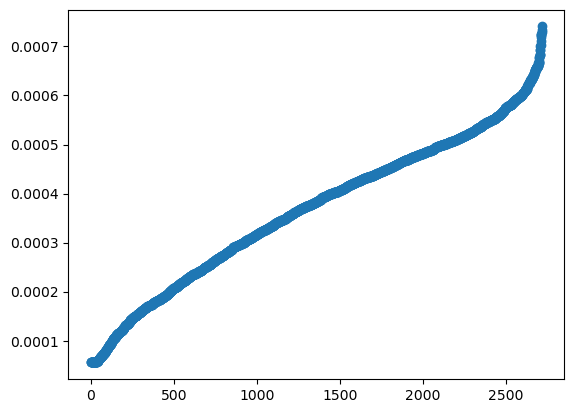

In [11]:
plt.scatter(list(pagerank.keys()),sorted(pagerank.values()))

(array([193., 260., 285., 333., 363., 452., 454., 262., 100.,  17.]),
 array([5.55668747e-05, 1.24074608e-04, 1.92582342e-04, 2.61090075e-04,
        3.29597809e-04, 3.98105542e-04, 4.66613276e-04, 5.35121009e-04,
        6.03628743e-04, 6.72136476e-04, 7.40644210e-04]),
 <BarContainer object of 10 artists>)

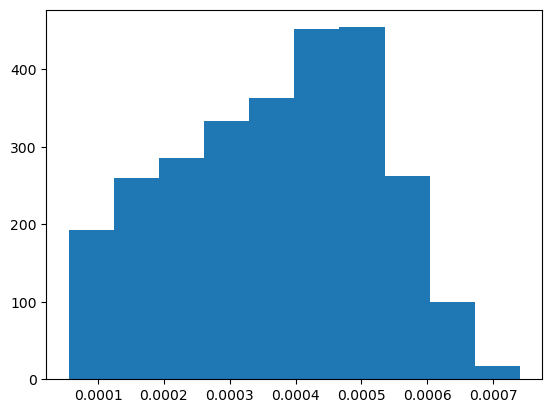

In [12]:
plt.hist(pagerank.values(), bins = 10)

### 2.4 NMF

In [24]:
# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer(min_df=50, stop_words='english')
 
# Fit and transform
X = vect.fit_transform(processed_data)

# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=5, random_state=20)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names_out())

In [25]:
#list to hold annotation
ann = []

#get top 10 words for each topic
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    ann.append('\n'.join(tmp.nlargest(10).index))
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
like         0.946443
character    0.933087
world        0.866811
wa           0.791792
story        0.771583
feel         0.753342
quest        0.669451
really       0.656942
dont         0.647884
good         0.563518
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
fps           1.242514
drop          1.026975
stutter       0.836357
frame         0.720000
unplayable    0.707877
setting       0.638845
stuttering    0.469361
ram           0.461216
rtx           0.397219
low           0.389110
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
crash       2.186179
crashing    0.292351
hour        0.272304
screen      0.241470
time        0.224266
pc          0.213994
minute      0.212580
save        0.193033
warning     0.167058
start       0.158353
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
performance    1.588756
issue          1.118386
pc            

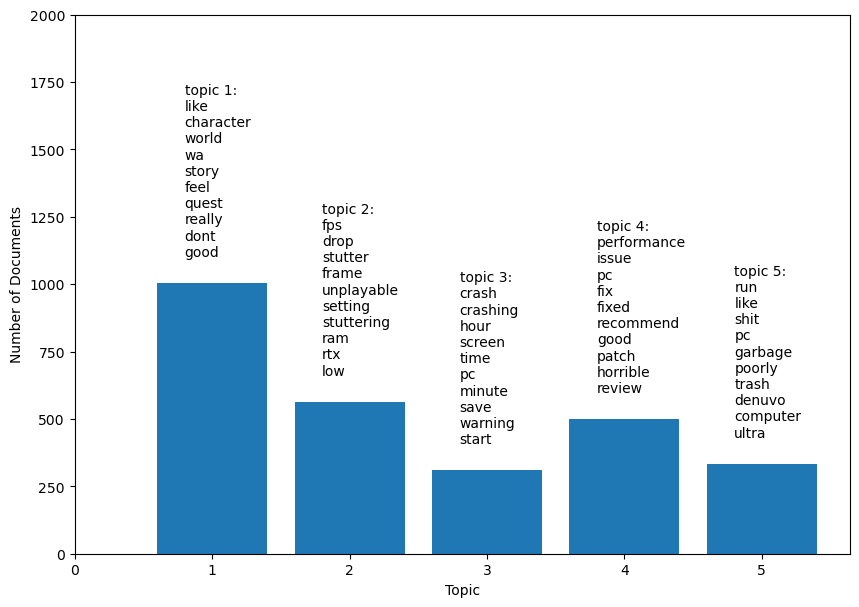

In [26]:
# count the number of documents belonging to each topic
topic_counts = [0] * model.n_components
for doc in nmf_features:
    topic = doc.argmax()
    topic_counts[topic] += 1

# create a bar chart of the topic counts
fig, ax = plt.subplots(figsize = (10, 7))
ax.bar(range(1,len(topic_counts)+1), topic_counts)
ax.set_xlabel("Topic")
ax.set_ylabel("Number of Documents")
ax.set_xticks(range(len(topic_counts)+1))
ax.set_ylim(top = 2000)

for i, a in enumerate(ann):
    ax.text(i+0.8, topic_counts[i] + 100, f"topic {i+1}:\n{a}")
plt.show()